# From Shakespearian to modern English

Elise Barrère (ENSAE) | Vincent Delale (ENSAE)

## Table of Contents
* [Explore the books](#exploration)
    * [Exploration based on the number of characters](#numchar)
    * [Exploration based on the number of words](#numwords)
    * [Wordclouds](#wordclouds)
* [Translation](#translation)
    * [Cleaning](#cleaning)
    * [Tokenization](#tokenization)
    * [Vocabulary](#vocab)
    * [Pytorch Model](#pytorch)
         * [Dataset](#dataset)
         * [Encoder](#encoder)
         * [Decoder](#decoder)
         * [Full Model](#fullmodel)
         * [Second Dataset](#2dataset)

* [Generation](#generation)

In [1]:
# download missing packages
! pip install transformers torchinfo sacrebleu termcolor bert_score

     |████████████████████████████████| 4.0 MB 28.1 MB/s 
     |████████████████████████████████| 90 kB 10.5 MB/s 
     |████████████████████████████████| 77 kB 7.1 MB/s 
     |████████████████████████████████| 6.6 MB 64.4 MB/s 
     |████████████████████████████████| 596 kB 47.2 MB/s 
     |████████████████████████████████| 895 kB 76.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
! pip install wordcloud --upgrade

     |████████████████████████████████| 366 kB 16.1 MB/s 
  Attempting uninstall: wordcloud
    Found existing installation: wordcloud 1.5.0
    Uninstalling wordcloud-1.5.0:
      Successfully uninstalled wordcloud-1.5.0


In [3]:
# Imports packages
import pandas as pd
pd.set_option('display.max_colwidth', None) 
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')
import seaborn as sns
import numpy as np

from wordcloud import WordCloud

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TreebankWordTokenizer
nltk.download('punkt')
nltk.download('stopwords')

from tqdm import tqdm
from termcolor import colored

from sacrebleu.metrics import BLEU
from bert_score import BERTScorer

from sklearn.model_selection import train_test_split


import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
# import data
url_books = 'https://raw.githubusercontent.com/vdelale/NLP-ENSAE/main/data/books/{}.csv'
book_titles = ['hamlet', 'lear', 'macbeth', 'othello']

full_books = []
for book in book_titles:
    tmp = pd.read_csv(url_books.format(book), index_col=0)
    tmp['book'] = book
    full_books.append(tmp)

In [5]:
df = pd.concat(full_books)
df.index = range(len(df))

In [6]:
df.head()

,original,modern,book
0,Who’s there?,Who’s there?,hamlet
1,"Nay, answer me. Stand and unfold yourself.","No, who are you? Stop and identify yourself.",hamlet
2,Long live the king!,Long live the king!,hamlet
3,Barnardo?,Is that Barnardo?,hamlet
4,He.,"Yes, it’s me.",hamlet


## Explore the books
<a class="anchor" id="exploration"></a>

### Exploration based on the number of characters
<a class="anchor" id="numchar"></a>


In [7]:
df['original_length'] = df.original.apply(lambda x : len(x.replace(' ', '')))
df['modern_length'] = df.modern.apply(lambda x : len(x.replace(' ', '')))

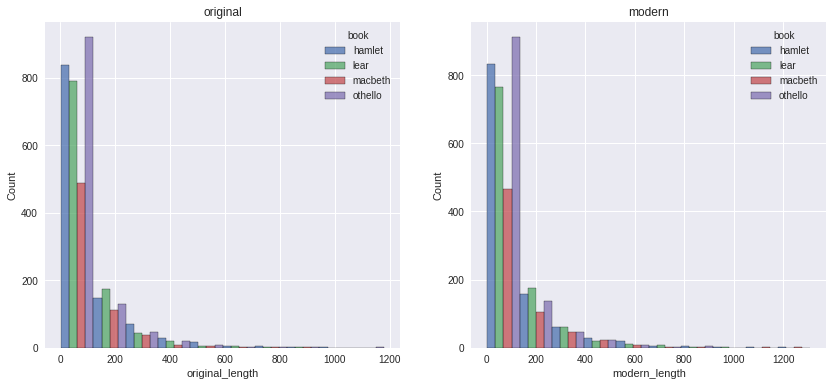

In [8]:
# Repartition of the content lengths (characters)

fig, axs = plt.subplots(1, 2, figsize=(14,6))
sns.histplot(data=df, x='original_length', ax=axs[0], hue='book', bins=10, multiple="dodge")
sns.histplot(data=df, x='modern_length', hue='book', ax=axs[1], bins=10,  multiple="dodge")

axs[0].set_title('original')
# sns.histplot(data=df, x='modern_length', hue='book')
axs[1].set_title('modern')

plt.show()

We can see that the repartition of line length is quite similar among the plays, except for othello which tend to be shorter.

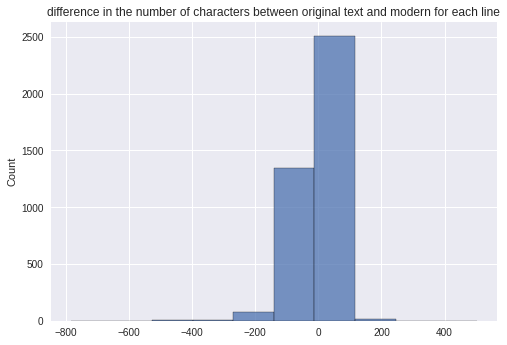

In [9]:
sns.histplot(df['original_length'] - df['modern_length'], bins=10)
plt.title('difference in the number of characters between original text and modern for each line')
plt.show()

We can see that overall there is not much difference in term of length between the orginal version of the text and its translation. But, the modern text tends to be a little bit longer. It can be due to the fact that the translation is made to help student understand the meaning of the text rather than being stylisticly pretty etc. Could also be because modern English requires more words/characters. 

### Exploration based on the number of words
<a class="anchor" id="numwords"></a>

In [10]:
df['original_words'] = df.original.apply(lambda x : len(x.split(' ')))
df['modern_words'] = df.modern.apply(lambda x : len(x.split(' ')))

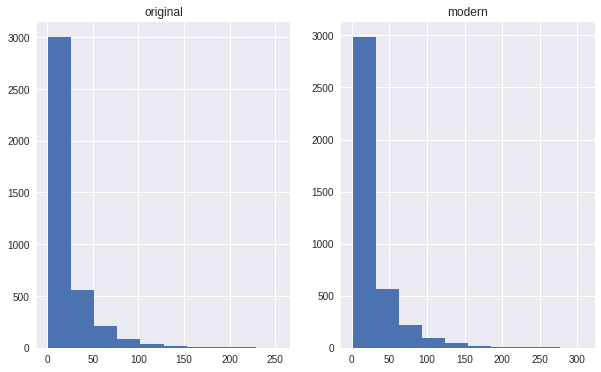

In [11]:
# Repartition of the content lengths (words)

fig, axs = plt.subplots(1, 2, figsize=(10,6))
axs[0].hist(df['original_words'])
axs[0].set_title('original')
axs[1].hist(df['modern_words'])
axs[1].set_title('modern')

plt.show()


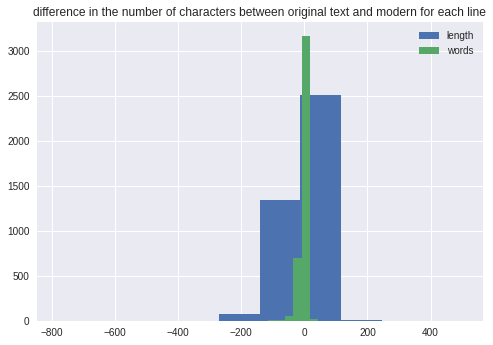

In [12]:
plt.hist(df['original_length'] - df['modern_length'], label='length')
plt.hist(df['original_words'] - df['modern_words'], label='words')
plt.legend()
plt.title('difference in the number of characters between original text and modern for each line')
plt.show()

Similarly, there is often an analogous number of words between the original and the modern text

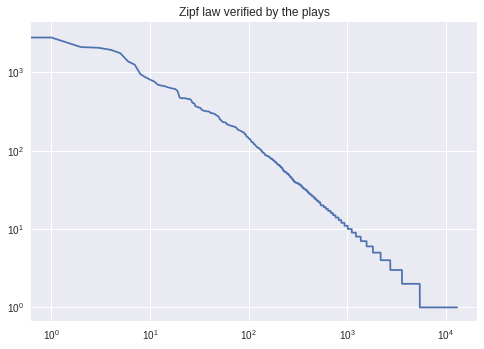

In [345]:
def count_words(full_play):
    flattened = []
    for words in full_play.split(' '):
        flattened.append(words)

    count_dict = {}
    word_sum = len(flattened)
    for word in flattened :
        count_dict[word] = count_dict.setdefault(word, 0) + 1
    df = pd.DataFrame(count_dict, index = ['word_count']).transpose().reset_index().sort_values(by = 'word_count', ascending = False)
    return df
df_count_words = count_words(" ".join(df['modern'].values))
plt.loglog(range(len(df_count_words)), df_count_words['word_count'])
plt.title('Zipf law verified by the plays')
plt.show()

### Wordclouds
<a class="anchor" id="wordclouds"></a>

In [13]:
modern_stopwords = set(stopwords.words('english'))
original_stopwords = pd.read_csv('https://raw.githubusercontent.com/vdelale/NLP-ENSAE/main/old_en_stopwords.txt',
                         header=None, names=['original'])['original'].values

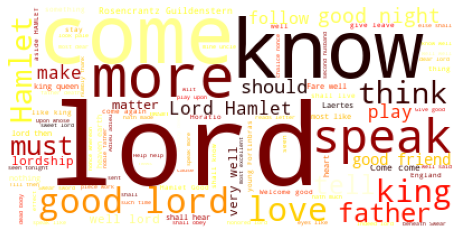

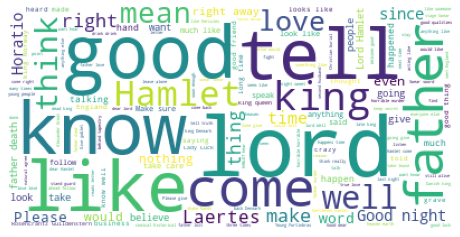

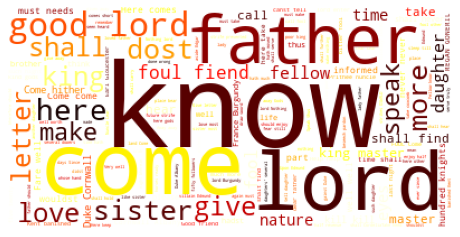

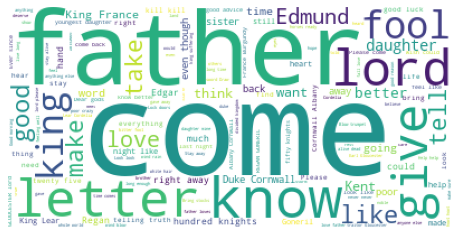

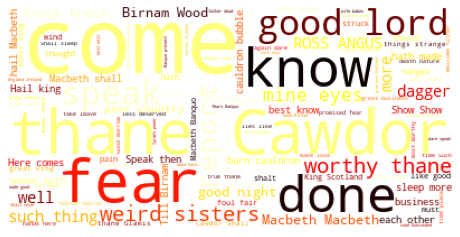

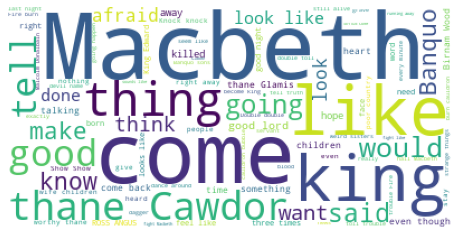

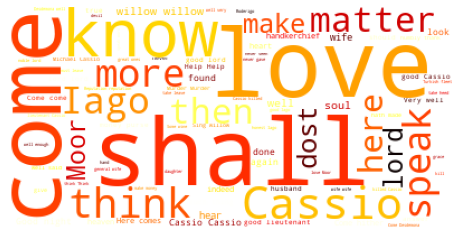

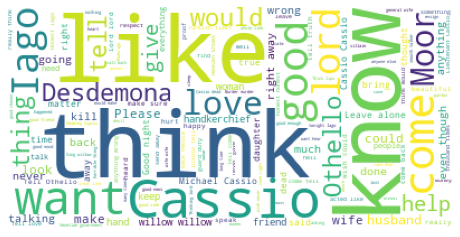

In [14]:
modern_text = " ".join(df['modern'].values)
original_text = " ".join(df['original'].values)
for b in df.book.unique():
    original_text_book = " ".join(df[df['book'] == b]['original'].values)
    wordcloud = WordCloud(background_color = 'white', stopwords = original_stopwords,
                          colormap=plt.cm.hot,
                          collocation_threshold=5, min_word_length=4).generate(original_text_book)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show();

    modern_text_book = " ".join(df[df['book'] == b]['modern'].values)
    wordcloud = WordCloud(background_color = 'white', stopwords = modern_stopwords,
                          collocation_threshold=5, min_word_length=4).generate(modern_text_book)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show();

## Translation
<a class="anchor" id="translation"></a>
### Cleaning
<a class="anchor" id="cleaning"></a>

In [15]:
import re
def remove_indications(text):
    new_text = re.sub("[\(].*?[\)]", "", text)
    return new_text
df['modern_clean'] = df['modern'].apply(remove_indications)

### Tokenization
<a class="anchor" id="tokenization"></a>

In [16]:
tok = TreebankWordTokenizer()

In [17]:
df['modern_tok'] = df['modern'].apply(lambda x: tok.tokenize(x.lower().strip()))
df['original_tok'] = df['original'].apply(lambda x: tok.tokenize(x.lower().strip()))

### Vocabulary
<a class="anchor" id="vocab"></a>

In [18]:
UNK_IDX, PAD_IDX, SOS_IDX, EOS_IDX = 0, 1, 2, 3
special_symbols = ['<unk>', '<pad>', '<sos>', '<eos>']

In [19]:
VOC = {'original_en': {'stoi': {}, 'counts': {}, 'nbwords': 0}, 'modern_en': {'stoi': {}, 'counts': {}, 'nbwords': 0}}

In [20]:
LANGS = ['original_en', 'modern_en']
for lang in LANGS:
  for t in special_symbols: 
    VOC[lang]['stoi'][t] = VOC[lang]['nbwords']
    VOC[lang]['counts'][t] = 1
    VOC[lang]['nbwords'] += 1

In [21]:
tokens_modern = df.modern_tok.values
for tokens in tokens_modern:
    for t in tokens:
        if t not in VOC['modern_en']['stoi']: 
            VOC['modern_en']['stoi'][t] = VOC['modern_en']['nbwords']
            VOC['modern_en']['counts'][t] = 1
            VOC['modern_en']['nbwords'] += 1
        else:
            VOC['modern_en']['counts'][t] = VOC['modern_en']['counts'][t] + 1

In [22]:
tokens_original = df.original_tok.values
for tokens in tokens_original:
    for t in tokens:
        if t not in VOC['original_en']['stoi']: 
            VOC['original_en']['stoi'][t] = VOC['original_en']['nbwords']
            VOC['original_en']['counts'][t] = 1
            VOC['original_en']['nbwords'] += 1
        else:
            VOC['original_en']['counts'][t] = VOC['original_en']['counts'][t] + 1

In [23]:
for lang in LANGS:
  VOC[lang]['itos'] = { v:k for k,v in VOC[lang]['stoi'].items()}

In [24]:
print('modern_en', VOC['modern_en']['nbwords'], 'original_en', VOC['original_en']['nbwords'])

modern_en 8778 original_en 9874


In [25]:
def prepa(entry, lang):
    tokens_entry =   [SOS_IDX] + [ VOC[lang]['stoi'][t] for t in entry ] + [EOS_IDX]   
    return tokens_entry

In [26]:
df['modern_en'] = df['modern_tok'].apply(lambda x: prepa(x, 'modern_en'))

In [27]:
df['original_en'] = df['original_tok'].apply(lambda x: prepa(x, 'original_en'))

In [28]:
from sklearn.model_selection import train_test_split

df_train, other = train_test_split(df, test_size=0.33, random_state=42)
df_test, df_val = train_test_split(other, test_size=0.5, random_state=42)


In [29]:
print(len(df_train), len(df_test), len(df_val))

2642 651 651


### Pytorch model
<a class="anchor" id="pytorch"></a>

In [30]:
import torch
if torch.cuda.is_available():
  # if CUDA is available set 'cuda' as the device
  device = 'cuda'
  # and then print the name of the GPU
  print('DEVICE = ',torch.cuda.get_device_name(0))
else:
  # else, set 'cpu' as device
  device = 'cpu'
  # just print than the CPU is used. Alternatively you can check your CPU with the following command (linux based) in the next cell:
  # ! lscpu
  print('DEVICE = ', 'CPU')

DEVICE =  Tesla T4


#### Dataset
<a class="anchor" id="dataset"></a>

In [31]:
class OrModDataset(Dataset):
    def __init__(self, data):
      self.data = data
    #   self.data_tensor = torch.tensor(self.data)
    #   self.transform = transform

    def __len__(self):
      return len(self.data)
    
    def __getitem__(self, idx):
      item = {
          "modern_en": torch.from_numpy(np.array(self.data.loc[idx]['modern_en'])),
          "original_en": torch.from_numpy(np.array(self.data.loc[idx]['original_en']))
      }
      return item


In [32]:
train_loader = DataLoader(OrModDataset(df_train.reset_index()), batch_size=1, shuffle=True, drop_last=True)
val_loader   = DataLoader(OrModDataset(df_val.reset_index()), batch_size=1, shuffle=True, drop_last=True)
test_loader  = DataLoader(OrModDataset(df_test.reset_index()), batch_size=1, shuffle=True, drop_last=True)

#### Encoder
<a class="anchor" id="encoder"></a>

In [61]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        # configurable hidden size
        self.hidden_size = hidden_size

        # we use an embedding layer
        self.embedding = nn.Embedding(input_size, hidden_size)
        # we define a GRU layer (Gated Recurrent Unit), a simpler version of recurrent layer and way simple than LSTM
        self.gru = nn.GRU(hidden_size, hidden_size)
        # added dropout to avoid overfitting
        self.dropout = nn.Dropout(0.2)

    def forward(self, input, hidden):
      # move the input to the dedicated device (CPU or GPU)
      input = input.to(device)
      # apply the embedding layer
      embedded = self.embedding(input)
      # modify the output shape in order for it to work with a GRU (we use batches of one element)
      output = embedded.view(1, 1, -1)
      # apply the GRU layer
      output, hidden = self.gru(output, hidden)
      # output = self.dropout(output)
      # return both the output, and the hidden vector
      return output, hidden

    def initHidden(self):
        """ 
        method used to customize the hidden vector initialization.
        here the vector is initialized as 0 with the correct shape and created directly on the correct device
        """
        return torch.zeros(1, 1, self.hidden_size, device=device)

#### Decoder
<a class="anchor" id="decoder"></a>

In [34]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        # configurable hidden size
        self.hidden_size = hidden_size

        # we use an embedding layer
        self.embedding = nn.Embedding(output_size, hidden_size)
        # we define a GRU layer (Gated Recurrent Unit), a simpler version of recurrent layer and way simple than LSTM
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
      # move the input to the dedicated device (CPU or GPU)
        input = input.to(device)
        # apply the embedding layer and modify the output shape in order for it to work with a GRU (we use batches of one element)
        output = self.embedding(input).view(1, 1, -1)
        # apply a ReLU non linearization layer
        output = F.relu(output)
        # apply the GRU layer
        output, hidden = self.gru(output, hidden)
        # apply a softmax to get probabilities, on the first element of the output vector (batch is equal to one)
        output = self.softmax(self.out(output[0]))
        # return both the output probabilities and the hidden vector
        return output, hidden

    def initHidden(self):
        """ 
        method used to customize the hidden vector initialization.
        here the vector is initialized as 0 with the correct shape and created directly on the correct device
        """
        return torch.zeros(1, 1, self.hidden_size, device=device)

#### Full Model
<a class="anchor" id="fullmodel"></a>

In [190]:
bert_scorer = BERTScorer(lang="en", rescale_with_baseline=True)

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/roberta-large/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/dea67b44b38d504f2523f3ddb6acb601b23d67bee52c942da336fa1283100990.94cae8b3a8dbab1d59b9d4827f7ce79e73124efa6bb970412cd503383a95f373
Model config RobertaConfig {
  "_name_or_path": "roberta-large",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.18.0",
  "type_vocab_size": 1,
  "use_c

In [264]:
import random 
teacher_forcing_ratio = 0.5

class seq2seqModel():
    def __init__(self, encoder, decoder, 
                 encoder_optimizer, decoder_optimizer,
                 criterion, VOC,
                 maxlen=50, teacher_forcing_ratio=0.5):
        self.encoder = encoder
        self.decoder = decoder        
        self.encoder_optimizer_func = encoder_optimizer
        self.decoder_optimizer_func = decoder_optimizer
        self.maxlen = maxlen
        self.teacher_forcing_ratio = teacher_forcing_ratio
        self.criterion = criterion
        self.VOC = VOC

    def train(self, input_tensor, target_tensor, max_length=0):
        # put both encoder and decoder into trainning mode
        self.encoder.train()
        self.decoder.train()
        if max_length == 0:
          max_length=self.maxlen

        # use our custom initialization of hidden vector
        encoder_hidden = self.encoder.initHidden()

        # remove the gradient to prevent gradient accumulation
        self.encoder_optimizer.zero_grad()
        self.decoder_optimizer.zero_grad()

        # adapt the tensor sizes
        input_tensor = input_tensor.view(input_tensor.size(1), input_tensor.size(0)) #input_tensor.view(1,1,-1)
        target_tensor = target_tensor.view(target_tensor.size(1), target_tensor.size(0)) #target_tensor.view(1,1,-1)

        # keep the lengths in memory
        input_length = input_tensor.size(0)
        target_length = target_tensor.size(0)

        # prepare an empty output with the correct size and the correct device
        encoder_outputs = torch.zeros(max_length, self.encoder.hidden_size, device=device)

        # init the loss to 0
        loss = 0

        # pass each token of the input_tensor to the encoder, then populate the output
        for ei in range(input_length):
          if ei >= self.maxlen: break
          encoder_output, encoder_hidden = self.encoder(input_tensor[ei], encoder_hidden)
          encoder_outputs[ei] = encoder_output[0, 0]

        # now we consider the decoder input, which starts only with the SOS token
        decoder_input = torch.tensor([[SOS_IDX]], device=device)

        # share the hidden vector from encoder to the decoder
        decoder_hidden = encoder_hidden

        # add a condition to teacher forcing
        use_teacher_forcing = True if random.random() < self.teacher_forcing_ratio else False

        if use_teacher_forcing:
            # Teacher forcing: Feed the target as the next input
            for di in range(target_length):
                decoder_output, decoder_hidden = self.decoder(
                    decoder_input, decoder_hidden)
                # apply the NLL loss
                loss += self.criterion(decoder_output.to(device), target_tensor[di].to(device))
                decoder_input = target_tensor[di]  # Teacher forcing

        else:
          # Without teacher forcing: use its own predictions as the next input
          for di in range(target_length):
              decoder_output, decoder_hidden = self.decoder(
                  decoder_input, decoder_hidden)
              topv, topi = decoder_output.topk(1)
              decoder_input = topi.squeeze().detach()  # detach from history as input
              # compute the loss
              loss += self.criterion(decoder_output, target_tensor[di].to(device))
              # stop the iteration if the EOS token is predicted
              if decoder_input.item() == EOS_IDX:
                  break
        
        # do the back propagation
        loss.backward()

        # notify each optimizers
        self.encoder_optimizer.step()
        self.decoder_optimizer.step()

        # return the average loss
        return loss.item() / target_length


    def sentence2tensor(self, entry, lang, VOC={}):
      """
      Function to transform an entry sentence into its corresponding indices as a tensor. 
      Needs to indicate the language to select the correct part of the vocabulary 
      """
      if VOC == {}:
          VOC = self.VOC
      indices = [SOS_IDX] + [ VOC[lang]['stoi'][t] if t in VOC[lang]['stoi'] else 0 for t in tok.tokenize(entry.lower().strip()) ] + [EOS_IDX]
      # print(indices)
      return torch.tensor(indices)

    def evaluate(self, sentence, input_lang, target_lang, max_length=0,
                 input_tensor=None, target_tensor=None):
        """
        function to evaluate a translation of one sentence
        """
        if max_length == 0:
            max_length=self.maxlen
        # we evaluate, so we don't need gradients -> torch.no_grad()
        with torch.no_grad():
            
            if target_tensor is None: target_length = 0
            else: target_length = target_tensor.size(0)

            encoder_hidden = self.encoder.initHidden()
            
            # this condition adapts the function to either use a sentence as input, or a tensor
            if input_tensor is None:
              input_tensor = self.sentence2tensor(sentence, input_lang)
              # adapts the decoding length, useful for validation or test
              decoding_length = max_length
            else:
              decoding_length = target_length
            
            input_length = input_tensor.size(0)

            encoder_outputs = torch.zeros(max_length, self.encoder.hidden_size, device=device)

            # iterate through the input length 
            for ei in range(input_length):
                if ei >= self.maxlen: break
                encoder_output, encoder_hidden = self.encoder(input_tensor[ei], encoder_hidden)
                encoder_outputs[ei] += encoder_output[0, 0]

            decoder_input = torch.tensor([[SOS_IDX]], device=device)  # SOS

            decoder_hidden = encoder_hidden

            decoded_words = []
            
            # init the loss (the loss is important is the cirterion is given - i.e. validation phase)
            loss = 0

            # iterate through decoding values, feeding the output for the next token until the condition or maximum lenght is reached
            for di in range(decoding_length):
                decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
                topv, topi = decoder_output.data.topk(1)
                if topi.item() == EOS_IDX:
                    decoded_words.append('<EOS>')
                    break
                else:
                    decoded_words.append(self.VOC[target_lang]['itos'][topi.item()])

                decoder_input = topi.squeeze().detach()

                if target_tensor != None and self.criterion is not None:
                  loss += self.criterion(decoder_output.to(device), target_tensor[di].unsqueeze(0).to(device))
                  if decoder_input.item() == EOS_IDX:
                    break

            return decoded_words, loss

    def inference(self, target, loader, langorder, limit=0):
      """
      fucntion to apply the inference logic over multiple translation and return a score
      used for validation
      """
      self.encoder.eval()
      self.decoder.eval()
      loss_it, glue_it = list(), list()
      preds, trues = list(), list()

      total = loader.__len__()
      if limit > 0: total = limit

      # iterate through the loader, can be a validation or test loader
      for it, batch in tqdm(enumerate(loader), desc="%s:" % (target), total=total):
        
        if limit > 0 and it >= limit: break

        input_tensor = batch[langorder[0]].squeeze()
        target_tensor = batch[langorder[1]].squeeze()

        input_lang = langorder[0]
        target_lang = langorder[1]
        # dummy sentence because this function is used for validation, not on-demand test
        mock_sentence = "dummy sentence not used"

        # compute entry and target sentences as "real text"
        entry = [self.VOC[input_lang]['itos'][t] for t in input_tensor.tolist()]
        entry = ' '.join( [e for e in entry if e not in ['<pad>', '<sos>', '<eos>', '<EOS>']] )
        true =  [self.VOC[target_lang]['itos'][t] for t in target_tensor.tolist()]
        true = ' '.join( [r for r in true if r not in ['<pad>', '<sos>', '<eos>', '<EOS>']] )
        trues.append([true])

        pred, loss = self.evaluate(mock_sentence, input_lang, target_lang, input_tensor=input_tensor,
                                   target_tensor=target_tensor)
        pred = ' '.join( [ h for h in pred if h not in ['<pad>', '<sos>', '<eos>', '<EOS>'] ] )
        preds.append(pred)
        if self.criterion is not None: 
          try:
            loss_it.append(loss.item())
          except: pass
        else: loss_it.append(loss)

      bleu = BLEU()
      bleu_score = bleu.corpus_score(preds, trues)
      # bert_score = bert_scorer.score(preds, trues)[2].mean()

      loss_it_avg = sum(loss_it)/len(loss_it)

      print("%s : (%s %s) (%s %s)" % ( colored(target, 'blue'), colored('loss', 'cyan'), loss_it_avg, colored('blue', 'cyan'), bleu_score ))

      return trues, preds, loss_it_avg, loss_it, bleu_score, 0

    def predict(self, sentence, input_lang, target_lang):
        pred, loss = self.evaluate(sentence, input_lang, target_lang)
        pred = ' '.join( [ h for h in pred if h not in ['<pad>', '<sos>', '<eos>', '<EOS>'] ] )
        return pred

    def run_epochs(self, train_loader, val_loader, max_epochs, learning_rate=0.01, langorder=['en','fr'], limit=0, 
                  patience=5):    
        
        # define the optimizer for both encoder and decoder separately.
        # You can change it later on
        self.encoder_optimizer = self.encoder_optimizer_func(self.encoder.parameters(), lr=learning_rate)
        self.decoder_optimizer = self.decoder_optimizer_func(self.decoder.parameters(), lr=learning_rate)

        epoch_losses = []
        val_epoch_losses = []
        patience_loss = 1000
        patience_counter = 1
        bleu_scores = []
        bert_scores = []

        for ep in range(max_epochs):
          
          # TRAINING
          it_losses = []

          total = train_loader.__len__()
          # allow to limit the number of random samples per epoch
          if limit > 0: total = limit

          for iter, batch in tqdm(enumerate(train_loader), desc="Epoch %s:" % (ep), total=total):
              # trigger the limit if it is set
              if limit > 0 and iter >= limit: break

              input_tensor = batch[langorder[0]]
              target_tensor = batch[langorder[1]]

              loss = self.train(input_tensor, target_tensor)
              it_losses.append(loss)
            #   print('loss', loss)
        #   print('epoch done')
          epoch_loss = sum(it_losses)/len(it_losses)
          epoch_losses.append(epoch_loss)
          print("Epoch %s : %s : (%s %s) " % (colored(str(ep), 'blue'), colored('Training', 'blue'), colored('loss', 'cyan'), epoch_loss  ))

          
          # VALIDATION
          trues, preds, val_loss_it_avg, val_loss_it, bleu_score, bert_score = self.inference("validation", val_loader, langorder, limit=limit)
          bleu_scores.append(bleu_score)
          bert_scores.append(bert_score)
          val_epoch_losses.append(val_loss_it_avg)

          if val_loss_it_avg > patience_loss:
              patience_counter += 1
          else:
              patience_loss = val_loss_it_avg
              patience_counter = 1 # reset
          
          if patience_counter > patience:
              break
  
        return epoch_losses, val_epoch_losses, bleu_scores, bert_scores


    def plot_loss(self, loss_list, path_save, title_):
      '''
      this function creates a plot. a simple curve showing the different values at each steps.
      Here we use it to plot the loss so we named it plot_loss, but the same function with different titles could be used to plot accuracies
      or other metrics for instance.
      
      Args:
        loss_list (list of floats): list of numerical values
      '''
      plt.plot(range(len(loss_list)), loss_list)
      plt.xlabel('epochs')
      plt.ylabel('cross entrepy')
      plt.title(title_)
      plt.savefig(path_save)
      plt.show()

    def print_translation(self, t):
        print(" ".join(t))

    def plot_scores(self, bert_scores, bleu_scores, path_save, title_):
        fig, ax1 = plt.subplots()

        color = 'tab:blue'
        ax1.set_xlabel('epochs')
        ax1.set_ylabel('bleu score', color=color)
        ax1.plot([float(str(k).split(' ')[2]) for k in bleu_scores], color=color)
        ax1.tick_params(axis='y', labelcolor=color)

        ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

        color = 'tab:red'
        ax2.set_ylabel('BERT score', color=color)  # we already handled the x-label with ax1
        ax2.plot(bert_scores, color=color)
        ax2.tick_params(axis='y', labelcolor=color)

        fig.tight_layout()  # otherwise the right y-label is slightly clipped
        plt.title(title_)
        plt.savefig(path_save)
        plt.show()

In [265]:
hidden_size = 512
langorder = ['original_en', 'modern_en']
epochs = 40

model = seq2seqModel(encoder=EncoderRNN(VOC[langorder[0]]['nbwords'], hidden_size).to(device),
                     decoder=DecoderRNN(hidden_size, VOC[langorder[1]]['nbwords']).to(device), 
                     encoder_optimizer=optim.Adam,
                     decoder_optimizer=optim.Adam,
                     criterion=nn.CrossEntropyLoss(),
                     VOC=VOC)

In [236]:
loss_list, val_loss_list, bleu_scores, bert_scores = model.run_epochs(train_loader,
                                                                      val_loader,
                                                                      epochs,
                                                                      learning_rate=0.001,
                                                                      limit=200,
                                                                      langorder=langorder, 
                                                                      patience=40)

Epoch 0:: 100%|██████████| 200/200 [00:16<00:00, 12.16it/s]


Epoch 0 : Training : (loss 4.106355749859284) 


validation:: 100%|██████████| 200/200 [00:06<00:00, 30.22it/s]


validation : (loss 131.86295385837556) (blue BLEU = 0.00 100.0/50.0/50.0/0.0 (BP = 1.000 ratio = 1.000 hyp_len = 3 ref_len = 3))


Epoch 1:: 100%|██████████| 200/200 [00:15<00:00, 13.05it/s]


Epoch 1 : Training : (loss 4.223336243908085) 


validation:: 100%|██████████| 200/200 [00:04<00:00, 40.15it/s]


validation : (loss 151.3738359451294) (blue BLEU = 21.36 100.0/20.0/12.5/8.3 (BP = 1.000 ratio = 1.000 hyp_len = 6 ref_len = 6))


Epoch 2:: 100%|██████████| 200/200 [00:13<00:00, 14.74it/s]


Epoch 2 : Training : (loss 4.351092944472746) 


validation:: 100%|██████████| 200/200 [00:04<00:00, 40.62it/s]


validation : (loss 153.63013086557388) (blue BLEU = 7.55 60.2/20.7/4.7/0.6 (BP = 0.989 ratio = 0.989 hyp_len = 88 ref_len = 89))


Epoch 3:: 100%|██████████| 200/200 [00:16<00:00, 12.15it/s]


Epoch 3 : Training : (loss 4.332478077559451) 


validation:: 100%|██████████| 200/200 [00:04<00:00, 45.80it/s]


validation : (loss 124.03409537434578) (blue BLEU = 25.85 100.0/37.5/14.3/8.3 (BP = 1.000 ratio = 1.000 hyp_len = 9 ref_len = 9))


Epoch 4:: 100%|██████████| 200/200 [00:14<00:00, 13.88it/s]


Epoch 4 : Training : (loss 4.263985188844888) 


validation:: 100%|██████████| 200/200 [00:03<00:00, 51.06it/s]


validation : (loss 105.98486843824386) (blue BLEU = 36.72 100.0/54.5/30.0/11.1 (BP = 1.000 ratio = 1.000 hyp_len = 12 ref_len = 12))


Epoch 5:: 100%|██████████| 200/200 [00:14<00:00, 14.02it/s]


Epoch 5 : Training : (loss 4.10209712269887) 


validation:: 100%|██████████| 200/200 [00:03<00:00, 50.12it/s]


validation : (loss 115.07727382421494) (blue BLEU = 4.60 53.1/6.3/1.6/0.8 (BP = 1.000 ratio = 1.000 hyp_len = 64 ref_len = 64))


Epoch 6:: 100%|██████████| 200/200 [00:15<00:00, 13.01it/s]


Epoch 6 : Training : (loss 4.167133575081779) 


validation:: 100%|██████████| 200/200 [00:05<00:00, 37.09it/s]


validation : (loss 173.29800044298173) (blue BLEU = 75.98 100.0/100.0/66.7/50.0 (BP = 1.000 ratio = 1.000 hyp_len = 5 ref_len = 5))


Epoch 7:: 100%|██████████| 200/200 [00:13<00:00, 14.49it/s]


Epoch 7 : Training : (loss 3.802826359989963) 


validation:: 100%|██████████| 200/200 [00:04<00:00, 40.56it/s]


validation : (loss 150.08478177905081) (blue BLEU = 9.41 85.7/25.0/2.6/1.4 (BP = 1.000 ratio = 1.000 hyp_len = 21 ref_len = 21))


Epoch 8:: 100%|██████████| 200/200 [00:14<00:00, 13.88it/s]


Epoch 8 : Training : (loss 4.115978103203721) 


validation:: 100%|██████████| 200/200 [00:03<00:00, 50.79it/s]


validation : (loss 111.71159697771073) (blue BLEU = 3.54 26.8/7.4/1.2/0.6 (BP = 1.000 ratio = 1.025 hyp_len = 82 ref_len = 80))


Epoch 9:: 100%|██████████| 200/200 [00:12<00:00, 15.68it/s]


Epoch 9 : Training : (loss 3.8524358566921872) 


validation:: 100%|██████████| 200/200 [00:04<00:00, 47.63it/s]


validation : (loss 120.17067381739616) (blue BLEU = 11.48 100.0/10.0/5.6/3.1 (BP = 1.000 ratio = 1.000 hyp_len = 11 ref_len = 11))


Epoch 10:: 100%|██████████| 200/200 [00:12<00:00, 16.01it/s]


Epoch 10 : Training : (loss 4.038578673698593) 


validation:: 100%|██████████| 200/200 [00:05<00:00, 38.18it/s]


KeyboardInterrupt: ignored

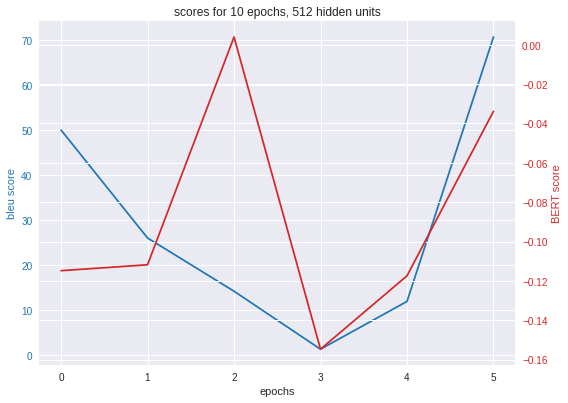

In [243]:
scheme_title='{} for {} epochs, {} hidden units'
scheme_path='graphs/{}_{}_{}'
n_epochs = 10
n_hidden = 512
model.plot_scores(bert_scores,
                  bleu_scores,
                  title_=scheme_title.format('scores', n_epochs, n_hidden), 
                  path_save=scheme_path.format('scores', n_epochs, n_hidden))

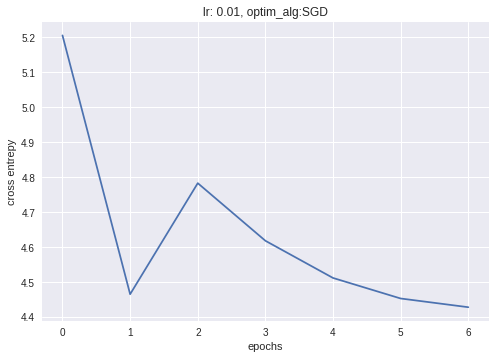

In [226]:
model.plot_loss(loss_list)

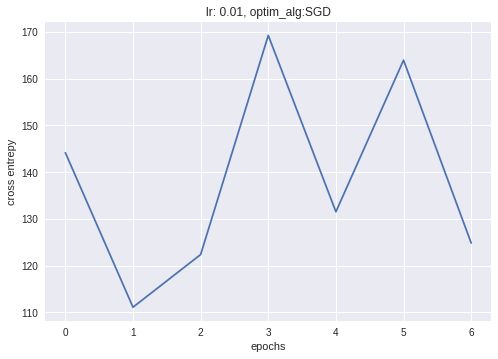

In [227]:
model.plot_loss(val_loss_list)


In [252]:
df_test['pred'] = df_test['original'].apply(lambda x: model.evaluate(x,input_lang='original_en',target_lang='modern_en')[0])

In [266]:
bert_scores = []
bleu_scores = []
for n_hidden in [256, 512] :
    for n_epochs in [5, 10, 20, 30, 40]:
        model = seq2seqModel(encoder=EncoderRNN(VOC[langorder[0]]['nbwords'], n_hidden).to(device),
                            decoder=DecoderRNN(n_hidden, VOC[langorder[1]]['nbwords']).to(device), 
                            encoder_optimizer=optim.Adam,
                            decoder_optimizer=optim.Adam,
                            criterion=nn.CrossEntropyLoss(),
                            VOC=VOC)
        
        loss_list, val_loss_list, bleu_scores, bert_scores = model.run_epochs(train_loader,
                                                                      val_loader,
                                                                      n_epochs,
                                                                      learning_rate=0.001,
                                                                      limit=200,
                                                                      langorder=langorder, 
                                                                      patience=40)
        
        df_test['pred'] = df_test['original'].apply(lambda x: model.evaluate(x,input_lang='original_en',target_lang='modern_en')[0])

        df_test['pred'] = df_test['pred'].apply(lambda x: ' '.join( [ h for h in x if h not in ['<pad>', '<sos>', '<eos>', '<EOS>'] ] ))
        bleu_score = bleu.corpus_score(list(df_test['pred']), list(df_test['modern']))
#       bert_score = bert_scorer.score(list(df_test['pred']), list(df_test['modern_tok']))[2].mean()
        bleu_scores.append(bleu_score)

Epoch 0:: 100%|██████████| 200/200 [00:08<00:00, 23.54it/s]


Epoch 0 : Training : (loss 5.417695134265857) 


validation:: 100%|██████████| 200/200 [00:03<00:00, 56.10it/s]


validation : (loss 91.38392398834229) (blue BLEU = 15.97 100.0/12.5/8.3/6.2 (BP = 1.000 ratio = 1.000 hyp_len = 5 ref_len = 5))


Epoch 1:: 100%|██████████| 200/200 [00:10<00:00, 19.35it/s]


Epoch 1 : Training : (loss 5.104382780241668) 


validation:: 100%|██████████| 200/200 [00:04<00:00, 48.83it/s]


validation : (loss 120.9093008184433) (blue BLEU = 0.00 100.0/100.0/50.0/0.0 (BP = 1.000 ratio = 1.000 hyp_len = 3 ref_len = 3))


Epoch 2:: 100%|██████████| 200/200 [00:09<00:00, 21.34it/s]


Epoch 2 : Training : (loss 4.605200543396286) 


validation:: 100%|██████████| 200/200 [00:05<00:00, 38.48it/s]


validation : (loss 174.27586616516112) (blue BLEU = 6.41 36.7/10.2/5.2/0.9 (BP = 1.000 ratio = 1.000 hyp_len = 60 ref_len = 60))


Epoch 3:: 100%|██████████| 200/200 [00:08<00:00, 24.85it/s]


Epoch 3 : Training : (loss 4.330749205559144) 


validation:: 100%|██████████| 200/200 [00:04<00:00, 46.59it/s]


validation : (loss 131.68445235729217) (blue BLEU = 13.30 100.0/23.8/5.0/2.6 (BP = 1.000 ratio = 1.000 hyp_len = 22 ref_len = 22))


Epoch 4:: 100%|██████████| 200/200 [00:09<00:00, 21.95it/s]


Epoch 4 : Training : (loss 4.470273216963431) 


validation:: 100%|██████████| 200/200 [00:02<00:00, 89.35it/s]


validation : (loss 41.83406861305237) (blue BLEU = 75.98 100.0/100.0/66.7/50.0 (BP = 1.000 ratio = 1.000 hyp_len = 5 ref_len = 5))


Epoch 0:: 100%|██████████| 200/200 [00:10<00:00, 19.81it/s]


Epoch 0 : Training : (loss 5.5679649761788905) 


validation:: 100%|██████████| 200/200 [00:05<00:00, 37.39it/s]


validation : (loss 174.72399772167205) (blue BLEU = 9.27 81.0/25.0/2.6/1.4 (BP = 1.000 ratio = 1.000 hyp_len = 21 ref_len = 21))


Epoch 1:: 100%|██████████| 200/200 [00:08<00:00, 24.35it/s]


Epoch 1 : Training : (loss 4.76539863861074) 


validation:: 100%|██████████| 200/200 [00:04<00:00, 45.40it/s]


validation : (loss 138.8407327222824) (blue BLEU = 27.78 100.0/66.7/12.5/7.1 (BP = 1.000 ratio = 1.000 hyp_len = 10 ref_len = 10))


Epoch 2:: 100%|██████████| 200/200 [00:08<00:00, 22.67it/s]


Epoch 2 : Training : (loss 4.551582365950614) 


validation:: 100%|██████████| 200/200 [00:03<00:00, 52.86it/s]


validation : (loss 106.8837329006195) (blue BLEU = 25.41 100.0/66.7/10.0/6.2 (BP = 1.000 ratio = 1.000 hyp_len = 7 ref_len = 7))


Epoch 3:: 100%|██████████| 200/200 [00:08<00:00, 23.80it/s]


Epoch 3 : Training : (loss 4.198495778746315) 


validation:: 100%|██████████| 200/200 [00:02<00:00, 86.73it/s]


validation : (loss 41.05356719017029) (blue BLEU = 35.36 100.0/75.0/16.7/12.5 (BP = 1.000 ratio = 1.000 hyp_len = 5 ref_len = 5))


Epoch 4:: 100%|██████████| 200/200 [00:09<00:00, 21.30it/s]


Epoch 4 : Training : (loss 4.17349829828234) 


validation:: 100%|██████████| 200/200 [00:04<00:00, 44.48it/s]


validation : (loss 140.91282900333405) (blue BLEU = 75.98 100.0/100.0/66.7/50.0 (BP = 1.000 ratio = 1.000 hyp_len = 5 ref_len = 5))


Epoch 5:: 100%|██████████| 200/200 [00:08<00:00, 22.69it/s]


Epoch 5 : Training : (loss 4.20192588869114) 


validation:: 100%|██████████| 200/200 [00:04<00:00, 43.57it/s]


validation : (loss 141.83464470863342) (blue BLEU = 50.00 100.0/100.0/25.0/25.0 (BP = 1.000 ratio = 1.000 hyp_len = 4 ref_len = 4))


Epoch 6:: 100%|██████████| 200/200 [00:08<00:00, 23.85it/s]


Epoch 6 : Training : (loss 4.344759803965001) 


validation:: 100%|██████████| 200/200 [00:02<00:00, 72.09it/s]


validation : (loss 62.541145210266116) (blue BLEU = 21.37 59.5/39.0/17.5/5.1 (BP = 1.000 ratio = 1.000 hyp_len = 42 ref_len = 42))


Epoch 7:: 100%|██████████| 200/200 [00:09<00:00, 22.19it/s]


Epoch 7 : Training : (loss 4.107373869594583) 


validation:: 100%|██████████| 200/200 [00:04<00:00, 45.43it/s]


validation : (loss 131.84691938877106) (blue BLEU = 60.43 100.0/80.0/50.0/33.3 (BP = 1.000 ratio = 1.000 hyp_len = 6 ref_len = 6))


Epoch 8:: 100%|██████████| 200/200 [00:09<00:00, 21.45it/s]


Epoch 8 : Training : (loss 4.230367067701444) 


validation:: 100%|██████████| 200/200 [00:03<00:00, 55.90it/s]


validation : (loss 99.08435524940491) (blue BLEU = 84.09 100.0/100.0/100.0/50.0 (BP = 1.000 ratio = 1.000 hyp_len = 5 ref_len = 5))


Epoch 9:: 100%|██████████| 200/200 [00:08<00:00, 23.10it/s]


Epoch 9 : Training : (loss 3.994057116776903) 


validation:: 100%|██████████| 200/200 [00:03<00:00, 66.65it/s]


validation : (loss 71.28208323001861) (blue BLEU = 84.09 100.0/100.0/100.0/50.0 (BP = 1.000 ratio = 1.000 hyp_len = 5 ref_len = 5))


Epoch 0:: 100%|██████████| 200/200 [00:08<00:00, 22.22it/s]


Epoch 0 : Training : (loss 5.7136661452040345) 


validation:: 100%|██████████| 200/200 [00:03<00:00, 53.26it/s]


validation : (loss 103.13631326675414) (blue BLEU = 13.89 100.0/12.5/7.1/4.2 (BP = 1.000 ratio = 1.000 hyp_len = 9 ref_len = 9))


Epoch 1:: 100%|██████████| 200/200 [00:08<00:00, 23.80it/s]


Epoch 1 : Training : (loss 4.845236689663278) 


validation:: 100%|██████████| 200/200 [00:02<00:00, 93.72it/s]


validation : (loss 35.710212426185606) (blue BLEU = 59.46 100.0/100.0/75.0/16.7 (BP = 1.000 ratio = 1.000 hyp_len = 6 ref_len = 6))


Epoch 2:: 100%|██████████| 200/200 [00:09<00:00, 21.56it/s]


Epoch 2 : Training : (loss 4.890582737770479) 


validation:: 100%|██████████| 200/200 [00:02<00:00, 77.47it/s]


validation : (loss 58.2544721364975) (blue BLEU = 50.00 100.0/75.0/33.3/25.0 (BP = 1.000 ratio = 1.000 hyp_len = 5 ref_len = 5))


Epoch 3:: 100%|██████████| 200/200 [00:08<00:00, 22.92it/s]


Epoch 3 : Training : (loss 4.453711840122647) 


validation:: 100%|██████████| 200/200 [00:05<00:00, 36.87it/s]


validation : (loss 185.84751724481583) (blue BLEU = 31.56 100.0/55.6/25.0/7.1 (BP = 1.000 ratio = 1.000 hyp_len = 10 ref_len = 10))


Epoch 4:: 100%|██████████| 200/200 [00:09<00:00, 21.98it/s]


Epoch 4 : Training : (loss 4.665832439564343) 


validation:: 100%|██████████| 200/200 [00:04<00:00, 41.17it/s]


validation : (loss 155.65983666419982) (blue BLEU = 58.14 100.0/85.7/66.7/20.0 (BP = 1.000 ratio = 1.000 hyp_len = 8 ref_len = 8))


Epoch 5:: 100%|██████████| 200/200 [00:08<00:00, 22.30it/s]


Epoch 5 : Training : (loss 4.306010849296542) 


validation:: 100%|██████████| 200/200 [00:03<00:00, 52.59it/s]


validation : (loss 110.94057275772094) (blue BLEU = 18.92 93.3/42.9/7.7/4.2 (BP = 1.000 ratio = 1.000 hyp_len = 15 ref_len = 15))


Epoch 6:: 100%|██████████| 200/200 [00:09<00:00, 21.32it/s]


Epoch 6 : Training : (loss 4.518279742154473) 


validation:: 100%|██████████| 200/200 [00:03<00:00, 54.83it/s]


validation : (loss 102.2068351316452) (blue BLEU = 26.86 100.0/25.0/16.7/12.5 (BP = 1.000 ratio = 1.000 hyp_len = 5 ref_len = 5))


Epoch 7:: 100%|██████████| 200/200 [00:08<00:00, 24.07it/s]


Epoch 7 : Training : (loss 4.270321602712571) 


validation:: 100%|██████████| 200/200 [00:04<00:00, 40.29it/s]


validation : (loss 156.01716394901277) (blue BLEU = 6.46 64.9/13.7/2.8/0.7 (BP = 1.000 ratio = 1.000 hyp_len = 74 ref_len = 74))


Epoch 8:: 100%|██████████| 200/200 [00:09<00:00, 20.33it/s]


Epoch 8 : Training : (loss 4.589823152473691) 


validation:: 100%|██████████| 200/200 [00:05<00:00, 39.42it/s]


validation : (loss 167.45014575004578) (blue BLEU = 22.16 89.5/25.0/14.5/7.4 (BP = 1.000 ratio = 1.000 hyp_len = 57 ref_len = 57))


Epoch 9:: 100%|██████████| 200/200 [00:08<00:00, 22.85it/s]


Epoch 9 : Training : (loss 4.2291338926131115) 


validation:: 100%|██████████| 200/200 [00:04<00:00, 43.69it/s]


validation : (loss 140.76312811851503) (blue BLEU = 45.18 100.0/50.0/33.3/25.0 (BP = 1.000 ratio = 1.000 hyp_len = 5 ref_len = 5))


Epoch 10:: 100%|██████████| 200/200 [00:08<00:00, 23.63it/s]


Epoch 10 : Training : (loss 4.2206371293982405) 


validation:: 100%|██████████| 200/200 [00:04<00:00, 47.26it/s]


validation : (loss 127.70369730949402) (blue BLEU = 63.89 100.0/66.7/50.0/50.0 (BP = 1.000 ratio = 1.000 hyp_len = 4 ref_len = 4))


Epoch 11:: 100%|██████████| 200/200 [00:09<00:00, 21.87it/s]


Epoch 11 : Training : (loss 4.130975480236604) 


validation:: 100%|██████████| 200/200 [00:03<00:00, 50.21it/s]


validation : (loss 114.70737179279327) (blue BLEU = 44.41 100.0/70.0/44.4/12.5 (BP = 1.000 ratio = 1.000 hyp_len = 11 ref_len = 11))


Epoch 12:: 100%|██████████| 200/200 [00:08<00:00, 22.67it/s]


Epoch 12 : Training : (loss 3.994264095103087) 


validation:: 100%|██████████| 200/200 [00:05<00:00, 39.63it/s]


validation : (loss 161.56736052036285) (blue BLEU = 2.20 23.5/7.2/0.5/0.3 (BP = 1.000 ratio = 1.010 hyp_len = 98 ref_len = 97))


Epoch 13:: 100%|██████████| 200/200 [00:10<00:00, 19.94it/s]


Epoch 13 : Training : (loss 4.092845341922407) 


validation:: 100%|██████████| 200/200 [00:03<00:00, 58.00it/s]


validation : (loss 90.01236955285073) (blue BLEU = 1.81 22.0/2.5/0.6/0.3 (BP = 1.000 ratio = 1.000 hyp_len = 82 ref_len = 82))


Epoch 14:: 100%|██████████| 200/200 [00:09<00:00, 20.50it/s]


Epoch 14 : Training : (loss 4.161479713627116) 


validation:: 100%|██████████| 200/200 [00:04<00:00, 45.64it/s]


validation : (loss 130.65396902561187) (blue BLEU = 79.53 100.0/80.0/75.0/66.7 (BP = 1.000 ratio = 1.000 hyp_len = 6 ref_len = 6))


Epoch 15:: 100%|██████████| 200/200 [00:08<00:00, 22.58it/s]


Epoch 15 : Training : (loss 3.8789033484762907) 


validation:: 100%|██████████| 200/200 [00:04<00:00, 41.31it/s]


validation : (loss 152.78370542168616) (blue BLEU = 63.89 100.0/66.7/50.0/50.0 (BP = 1.000 ratio = 1.000 hyp_len = 4 ref_len = 4))


Epoch 16:: 100%|██████████| 200/200 [00:08<00:00, 23.92it/s]


Epoch 16 : Training : (loss 3.9876289611152527) 


validation:: 100%|██████████| 200/200 [00:04<00:00, 42.53it/s]


validation : (loss 149.68852725744247) (blue BLEU = 0.00 50.0/50.0/0.0/0.0 (BP = 1.000 ratio = 1.000 hyp_len = 2 ref_len = 2))


Epoch 17:: 100%|██████████| 200/200 [00:08<00:00, 23.51it/s]


Epoch 17 : Training : (loss 4.057807316991315) 


validation:: 100%|██████████| 200/200 [00:04<00:00, 40.42it/s]


validation : (loss 154.0315367257595) (blue BLEU = 19.26 84.2/22.2/11.8/6.2 (BP = 1.000 ratio = 1.000 hyp_len = 19 ref_len = 19))


Epoch 18:: 100%|██████████| 200/200 [00:08<00:00, 24.15it/s]


Epoch 18 : Training : (loss 3.8354288234105667) 


validation:: 100%|██████████| 200/200 [00:03<00:00, 57.24it/s]


validation : (loss 96.83633526206016) (blue BLEU = 25.41 100.0/40.0/12.5/8.3 (BP = 1.000 ratio = 1.000 hyp_len = 6 ref_len = 6))


Epoch 19:: 100%|██████████| 200/200 [00:08<00:00, 23.07it/s]


Epoch 19 : Training : (loss 3.695314263030002) 


validation:: 100%|██████████| 200/200 [00:04<00:00, 47.77it/s]


validation : (loss 133.7011580467224) (blue BLEU = 50.81 100.0/66.7/40.0/25.0 (BP = 1.000 ratio = 1.000 hyp_len = 7 ref_len = 7))


Epoch 0:: 100%|██████████| 200/200 [00:08<00:00, 24.89it/s]


Epoch 0 : Training : (loss 5.306264829178913) 


validation:: 100%|██████████| 200/200 [00:05<00:00, 34.09it/s]


validation : (loss 195.28227619171142) (blue BLEU = 9.36 70.3/20.6/3.2/1.6 (BP = 1.000 ratio = 1.016 hyp_len = 64 ref_len = 63))


Epoch 1:: 100%|██████████| 200/200 [00:08<00:00, 23.84it/s]


Epoch 1 : Training : (loss 4.766613682600817) 


validation:: 100%|██████████| 200/200 [00:05<00:00, 36.45it/s]


validation : (loss 189.85503860473634) (blue BLEU = 29.85 88.9/75.0/14.3/8.3 (BP = 1.000 ratio = 1.000 hyp_len = 9 ref_len = 9))


Epoch 2:: 100%|██████████| 200/200 [00:08<00:00, 23.43it/s]


Epoch 2 : Training : (loss 4.567879362304517) 


validation:: 100%|██████████| 200/200 [00:02<00:00, 76.91it/s]


validation : (loss 49.60240797996521) (blue BLEU = 31.24 100.0/57.1/16.7/10.0 (BP = 1.000 ratio = 1.000 hyp_len = 8 ref_len = 8))


Epoch 3:: 100%|██████████| 200/200 [00:08<00:00, 23.36it/s]


Epoch 3 : Training : (loss 4.239951728890621) 


validation:: 100%|██████████| 200/200 [00:05<00:00, 39.96it/s]


validation : (loss 161.0769671535492) (blue BLEU = 2.78 28.0/7.2/1.1/0.3 (BP = 0.989 ratio = 0.989 hyp_len = 182 ref_len = 184))


Epoch 4:: 100%|██████████| 200/200 [00:08<00:00, 23.51it/s]


Epoch 4 : Training : (loss 4.319613283955269) 


validation:: 100%|██████████| 200/200 [00:04<00:00, 41.61it/s]


validation : (loss 157.98784287929536) (blue BLEU = 8.23 100.0/6.7/3.6/1.9 (BP = 1.000 ratio = 1.000 hyp_len = 16 ref_len = 16))


Epoch 5:: 100%|██████████| 200/200 [00:09<00:00, 21.22it/s]


Epoch 5 : Training : (loss 4.547019286966699) 


validation:: 100%|██████████| 200/200 [00:03<00:00, 50.79it/s]


validation : (loss 113.27879712343216) (blue BLEU = 5.26 56.0/12.2/2.6/0.4 (BP = 0.991 ratio = 0.991 hyp_len = 116 ref_len = 117))


Epoch 6:: 100%|██████████| 200/200 [00:09<00:00, 21.66it/s]


Epoch 6 : Training : (loss 4.398465894574617) 


validation:: 100%|██████████| 200/200 [00:04<00:00, 40.85it/s]


validation : (loss 153.24656454086303) (blue BLEU = 71.86 100.0/100.0/66.7/40.0 (BP = 1.000 ratio = 1.000 hyp_len = 8 ref_len = 8))


Epoch 7:: 100%|██████████| 200/200 [00:08<00:00, 22.38it/s]


Epoch 7 : Training : (loss 4.173088340314835) 


validation:: 100%|██████████| 200/200 [00:03<00:00, 57.72it/s]


validation : (loss 93.44894267559052) (blue BLEU = 60.43 100.0/80.0/50.0/33.3 (BP = 1.000 ratio = 1.000 hyp_len = 6 ref_len = 6))


Epoch 8:: 100%|██████████| 200/200 [00:08<00:00, 24.80it/s]


Epoch 8 : Training : (loss 4.00671181188829) 


validation:: 100%|██████████| 200/200 [00:03<00:00, 63.13it/s]


validation : (loss 73.36219873666764) (blue BLEU = 32.47 100.0/40.0/22.2/12.5 (BP = 1.000 ratio = 1.000 hyp_len = 11 ref_len = 11))


Epoch 9:: 100%|██████████| 200/200 [00:08<00:00, 22.82it/s]


Epoch 9 : Training : (loss 4.100043121051768) 


validation:: 100%|██████████| 200/200 [00:04<00:00, 49.03it/s]


validation : (loss 122.62131916999817) (blue BLEU = 7.57 88.2/6.2/3.3/1.8 (BP = 1.000 ratio = 1.000 hyp_len = 17 ref_len = 17))


Epoch 10:: 100%|██████████| 200/200 [00:09<00:00, 20.05it/s]


Epoch 10 : Training : (loss 4.236810156374395) 


validation:: 100%|██████████| 200/200 [00:03<00:00, 60.73it/s]


validation : (loss 85.33552974253892) (blue BLEU = 18.21 100.0/20.0/14.3/3.8 (BP = 1.000 ratio = 1.000 hyp_len = 16 ref_len = 16))


Epoch 11:: 100%|██████████| 200/200 [00:09<00:00, 21.59it/s]


Epoch 11 : Training : (loss 3.877487151551657) 


validation:: 100%|██████████| 200/200 [00:04<00:00, 43.95it/s]


validation : (loss 136.36607949256896) (blue BLEU = 23.36 100.0/33.3/12.5/7.1 (BP = 1.000 ratio = 1.000 hyp_len = 10 ref_len = 10))


Epoch 12:: 100%|██████████| 200/200 [00:08<00:00, 22.74it/s]


Epoch 12 : Training : (loss 4.007055563048411) 


validation:: 100%|██████████| 200/200 [00:04<00:00, 48.83it/s]


validation : (loss 120.46316358804702) (blue BLEU = 16.45 100.0/26.7/7.1/3.8 (BP = 1.000 ratio = 1.000 hyp_len = 16 ref_len = 16))


Epoch 13:: 100%|██████████| 200/200 [00:08<00:00, 23.33it/s]


Epoch 13 : Training : (loss 4.135787870908751) 


validation:: 100%|██████████| 200/200 [00:04<00:00, 48.28it/s]


validation : (loss 119.34993854522705) (blue BLEU = 0.00 100.0/50.0/50.0/0.0 (BP = 1.000 ratio = 1.000 hyp_len = 3 ref_len = 3))


Epoch 14:: 100%|██████████| 200/200 [00:07<00:00, 26.46it/s]


Epoch 14 : Training : (loss 3.7052936178944673) 


validation:: 100%|██████████| 200/200 [00:03<00:00, 63.83it/s]


validation : (loss 77.31143257319927) (blue BLEU = 100.00 100.0/100.0/100.0/100.0 (BP = 1.000 ratio = 1.000 hyp_len = 4 ref_len = 4))


Epoch 15:: 100%|██████████| 200/200 [00:09<00:00, 21.73it/s]


Epoch 15 : Training : (loss 3.889174541575612) 


validation:: 100%|██████████| 200/200 [00:04<00:00, 42.12it/s]


validation : (loss 145.14454226970673) (blue BLEU = 16.27 58.8/25.0/13.3/3.6 (BP = 1.000 ratio = 1.000 hyp_len = 17 ref_len = 17))


Epoch 16:: 100%|██████████| 200/200 [00:09<00:00, 21.59it/s]


Epoch 16 : Training : (loss 3.9220842858230496) 


validation:: 100%|██████████| 200/200 [00:05<00:00, 36.22it/s]


validation : (loss 178.55969775676726) (blue BLEU = 11.95 100.0/11.1/5.9/3.1 (BP = 1.000 ratio = 1.000 hyp_len = 19 ref_len = 19))


Epoch 17:: 100%|██████████| 200/200 [00:08<00:00, 22.30it/s]


Epoch 17 : Training : (loss 3.876554009503752) 


validation:: 100%|██████████| 200/200 [00:04<00:00, 42.11it/s]


validation : (loss 147.79109268188478) (blue BLEU = 14.00 75.0/33.9/8.6/1.8 (BP = 1.000 ratio = 1.000 hyp_len = 60 ref_len = 60))


Epoch 18:: 100%|██████████| 200/200 [00:09<00:00, 21.53it/s]


Epoch 18 : Training : (loss 3.8942874867918755) 


validation:: 100%|██████████| 200/200 [00:03<00:00, 54.28it/s]


validation : (loss 99.79960205137729) (blue BLEU = 10.88 68.0/20.8/4.3/2.3 (BP = 1.000 ratio = 1.000 hyp_len = 25 ref_len = 25))


Epoch 19:: 100%|██████████| 200/200 [00:08<00:00, 24.76it/s]


Epoch 19 : Training : (loss 3.7896122816456104) 


validation:: 100%|██████████| 200/200 [00:03<00:00, 55.47it/s]


validation : (loss 95.44317593812943) (blue BLEU = 8.23 100.0/6.7/3.6/1.9 (BP = 1.000 ratio = 1.000 hyp_len = 16 ref_len = 16))


Epoch 20:: 100%|██████████| 200/200 [00:08<00:00, 23.19it/s]


Epoch 20 : Training : (loss 3.7921116354858992) 


validation:: 100%|██████████| 200/200 [00:04<00:00, 45.67it/s]


validation : (loss 130.55591517448426) (blue BLEU = 10.24 56.6/19.2/5.9/2.0 (BP = 0.963 ratio = 0.964 hyp_len = 53 ref_len = 55))


Epoch 21:: 100%|██████████| 200/200 [00:08<00:00, 22.82it/s]


Epoch 21 : Training : (loss 3.923059109026627) 


validation:: 100%|██████████| 200/200 [00:05<00:00, 35.82it/s]


validation : (loss 180.32179494380952) (blue BLEU = 2.38 34.5/2.5/0.9/0.4 (BP = 1.000 ratio = 1.000 hyp_len = 119 ref_len = 119))


Epoch 22:: 100%|██████████| 200/200 [00:10<00:00, 19.90it/s]


Epoch 22 : Training : (loss 3.820290339725679) 


validation:: 100%|██████████| 200/200 [00:04<00:00, 44.77it/s]


validation : (loss 137.40137327432632) (blue BLEU = 90.36 100.0/100.0/100.0/66.7 (BP = 1.000 ratio = 1.000 hyp_len = 6 ref_len = 6))


Epoch 23:: 100%|██████████| 200/200 [00:09<00:00, 20.72it/s]


Epoch 23 : Training : (loss 3.6319820753147884) 


validation:: 100%|██████████| 200/200 [00:04<00:00, 47.42it/s]


validation : (loss 124.48728473424912) (blue BLEU = 39.76 100.0/60.0/25.0/16.7 (BP = 1.000 ratio = 1.000 hyp_len = 6 ref_len = 6))


Epoch 24:: 100%|██████████| 200/200 [00:09<00:00, 20.44it/s]


Epoch 24 : Training : (loss 3.9400639837590963) 


validation:: 100%|██████████| 200/200 [00:04<00:00, 47.78it/s]


validation : (loss 128.74873011469842) (blue BLEU = 0.00 100.0/100.0/0.0/0.0 (BP = 1.000 ratio = 1.000 hyp_len = 2 ref_len = 2))


Epoch 25:: 100%|██████████| 200/200 [00:08<00:00, 22.55it/s]


Epoch 25 : Training : (loss 3.6599011669747306) 


validation:: 100%|██████████| 200/200 [00:04<00:00, 47.91it/s]


validation : (loss 126.25046922802925) (blue BLEU = 20.56 100.0/42.9/8.3/5.0 (BP = 1.000 ratio = 1.000 hyp_len = 8 ref_len = 8))


Epoch 26:: 100%|██████████| 200/200 [00:09<00:00, 20.33it/s]


Epoch 26 : Training : (loss 3.6929423527889664) 


validation:: 100%|██████████| 200/200 [00:03<00:00, 51.63it/s]


validation : (loss 109.33795181035995) (blue BLEU = 45.18 100.0/66.7/25.0/25.0 (BP = 1.000 ratio = 1.000 hyp_len = 4 ref_len = 4))


Epoch 27:: 100%|██████████| 200/200 [00:07<00:00, 25.11it/s]


Epoch 27 : Training : (loss 3.5958364633582205) 


validation:: 100%|██████████| 200/200 [00:03<00:00, 52.02it/s]


validation : (loss 109.35058944940567) (blue BLEU = 30.21 100.0/33.3/20.0/12.5 (BP = 1.000 ratio = 1.000 hyp_len = 7 ref_len = 7))


Epoch 28:: 100%|██████████| 200/200 [00:08<00:00, 24.36it/s]


Epoch 28 : Training : (loss 3.527377496133937) 


validation:: 100%|██████████| 200/200 [00:04<00:00, 41.40it/s]


validation : (loss 156.8797334945202) (blue BLEU = 34.93 100.0/62.5/28.6/8.3 (BP = 1.000 ratio = 1.000 hyp_len = 9 ref_len = 9))


Epoch 29:: 100%|██████████| 200/200 [00:08<00:00, 23.10it/s]


Epoch 29 : Training : (loss 3.6299614664201574) 


validation:: 100%|██████████| 200/200 [00:03<00:00, 50.45it/s]


validation : (loss 115.78436468183995) (blue BLEU = 45.18 100.0/66.7/25.0/25.0 (BP = 1.000 ratio = 1.000 hyp_len = 4 ref_len = 4))


Epoch 0:: 100%|██████████| 200/200 [00:08<00:00, 24.09it/s]


Epoch 0 : Training : (loss 5.28049818742279) 


validation:: 100%|██████████| 200/200 [00:06<00:00, 31.93it/s]


validation : (loss 210.5554468202591) (blue BLEU = 3.76 57.1/2.9/1.5/0.8 (BP = 1.000 ratio = 1.000 hyp_len = 35 ref_len = 35))


Epoch 1:: 100%|██████████| 200/200 [00:08<00:00, 23.58it/s]


Epoch 1 : Training : (loss 4.6349010213598) 


validation:: 100%|██████████| 200/200 [00:03<00:00, 63.33it/s]


validation : (loss 85.41202222824097) (blue BLEU = 35.36 100.0/75.0/16.7/12.5 (BP = 1.000 ratio = 1.000 hyp_len = 5 ref_len = 5))


Epoch 2:: 100%|██████████| 200/200 [00:09<00:00, 20.46it/s]


Epoch 2 : Training : (loss 4.897807003582831) 


validation:: 100%|██████████| 200/200 [00:04<00:00, 44.13it/s]


validation : (loss 137.72094511032105) (blue BLEU = 1.28 17.2/1.7/0.4/0.2 (BP = 0.983 ratio = 0.983 hyp_len = 116 ref_len = 118))


Epoch 3:: 100%|██████████| 200/200 [00:09<00:00, 21.84it/s]


Epoch 3 : Training : (loss 4.48273211806766) 


validation:: 100%|██████████| 200/200 [00:03<00:00, 65.02it/s]


validation : (loss 76.13710012435914) (blue BLEU = 42.73 100.0/80.0/25.0/16.7 (BP = 1.000 ratio = 1.000 hyp_len = 6 ref_len = 6))


Epoch 4:: 100%|██████████| 200/200 [00:07<00:00, 25.48it/s]


Epoch 4 : Training : (loss 4.022573839621784) 


validation:: 100%|██████████| 200/200 [00:05<00:00, 36.15it/s]


validation : (loss 178.53978339672088) (blue BLEU = 27.45 89.7/52.6/21.6/5.6 (BP = 1.000 ratio = 1.026 hyp_len = 39 ref_len = 38))


Epoch 5:: 100%|██████████| 200/200 [00:09<00:00, 20.83it/s]


Epoch 5 : Training : (loss 4.476098887872401) 


validation:: 100%|██████████| 200/200 [00:03<00:00, 60.35it/s]


validation : (loss 91.72816664695739) (blue BLEU = 0.00 100.0/100.0/100.0/0.0 (BP = 1.000 ratio = 1.000 hyp_len = 3 ref_len = 3))


Epoch 6:: 100%|██████████| 200/200 [00:08<00:00, 22.87it/s]


Epoch 6 : Training : (loss 4.358914301382813) 


validation:: 100%|██████████| 200/200 [00:03<00:00, 52.07it/s]


validation : (loss 111.91988686323165) (blue BLEU = 60.43 100.0/80.0/50.0/33.3 (BP = 1.000 ratio = 1.000 hyp_len = 6 ref_len = 6))


Epoch 7:: 100%|██████████| 200/200 [00:09<00:00, 21.68it/s]


Epoch 7 : Training : (loss 4.406085621747527) 


validation:: 100%|██████████| 200/200 [00:05<00:00, 35.18it/s]


validation : (loss 185.29762882232666) (blue BLEU = 6.90 88.9/5.7/2.9/1.5 (BP = 1.000 ratio = 1.000 hyp_len = 36 ref_len = 36))


Epoch 8:: 100%|██████████| 200/200 [00:09<00:00, 20.71it/s]


Epoch 8 : Training : (loss 4.365496333991543) 


validation:: 100%|██████████| 200/200 [00:04<00:00, 43.10it/s]


validation : (loss 138.87226080179215) (blue BLEU = 16.52 100.0/33.3/6.2/3.6 (BP = 1.000 ratio = 1.000 hyp_len = 10 ref_len = 10))


Epoch 9:: 100%|██████████| 200/200 [00:08<00:00, 22.46it/s]


Epoch 9 : Training : (loss 4.223139148740397) 


validation:: 100%|██████████| 200/200 [00:03<00:00, 62.30it/s]


validation : (loss 77.25099974155427) (blue BLEU = 25.85 100.0/37.5/14.3/8.3 (BP = 1.000 ratio = 1.000 hyp_len = 9 ref_len = 9))


Epoch 10:: 100%|██████████| 200/200 [00:09<00:00, 21.09it/s]


Epoch 10 : Training : (loss 4.066980895786497) 


validation:: 100%|██████████| 200/200 [00:02<00:00, 68.05it/s]


validation : (loss 70.47814648389816) (blue BLEU = 39.76 100.0/60.0/25.0/16.7 (BP = 1.000 ratio = 1.000 hyp_len = 6 ref_len = 6))


Epoch 11:: 100%|██████████| 200/200 [00:08<00:00, 22.70it/s]


Epoch 11 : Training : (loss 4.020894930286446) 


validation:: 100%|██████████| 200/200 [00:03<00:00, 52.93it/s]


validation : (loss 102.22812252521516) (blue BLEU = 30.21 100.0/60.0/22.2/6.2 (BP = 1.000 ratio = 1.000 hyp_len = 11 ref_len = 11))


Epoch 12:: 100%|██████████| 200/200 [00:08<00:00, 23.55it/s]


Epoch 12 : Training : (loss 3.875634771918267) 


validation:: 100%|██████████| 200/200 [00:05<00:00, 37.72it/s]


validation : (loss 171.09408410072328) (blue BLEU = 37.15 100.0/57.1/33.3/10.0 (BP = 1.000 ratio = 1.000 hyp_len = 8 ref_len = 8))


Epoch 13:: 100%|██████████| 200/200 [00:09<00:00, 21.63it/s]


Epoch 13 : Training : (loss 4.0308592404861) 


validation:: 100%|██████████| 200/200 [00:03<00:00, 52.48it/s]


validation : (loss 106.86043406128883) (blue BLEU = 0.00 100.0/100.0/100.0/0.0 (BP = 1.000 ratio = 1.000 hyp_len = 3 ref_len = 3))


Epoch 14:: 100%|██████████| 200/200 [00:09<00:00, 20.70it/s]


Epoch 14 : Training : (loss 4.032572731695801) 


validation:: 100%|██████████| 200/200 [00:04<00:00, 45.19it/s]


validation : (loss 131.38117381811142) (blue BLEU = 1.50 29.5/2.3/0.4/0.2 (BP = 1.000 ratio = 1.048 hyp_len = 132 ref_len = 126))


Epoch 15:: 100%|██████████| 200/200 [00:09<00:00, 21.41it/s]


Epoch 15 : Training : (loss 4.047108920164752) 


validation:: 100%|██████████| 200/200 [00:05<00:00, 39.63it/s]


validation : (loss 168.87337646007538) (blue BLEU = 29.07 100.0/42.9/16.7/10.0 (BP = 1.000 ratio = 1.000 hyp_len = 8 ref_len = 8))


Epoch 16:: 100%|██████████| 200/200 [00:09<00:00, 20.44it/s]


Epoch 16 : Training : (loss 3.944468851628664) 


validation:: 100%|██████████| 200/200 [00:04<00:00, 41.09it/s]


validation : (loss 150.0690121126175) (blue BLEU = 45.18 100.0/50.0/33.3/25.0 (BP = 1.000 ratio = 1.000 hyp_len = 5 ref_len = 5))


Epoch 17:: 100%|██████████| 200/200 [00:08<00:00, 23.46it/s]


Epoch 17 : Training : (loss 4.068712294786799) 


validation:: 100%|██████████| 200/200 [00:04<00:00, 43.88it/s]


validation : (loss 133.63040411233902) (blue BLEU = 70.71 100.0/75.0/66.7/50.0 (BP = 1.000 ratio = 1.000 hyp_len = 5 ref_len = 5))


Epoch 18:: 100%|██████████| 200/200 [00:08<00:00, 24.25it/s]


Epoch 18 : Training : (loss 3.851772180564587) 


validation:: 100%|██████████| 200/200 [00:03<00:00, 50.90it/s]


validation : (loss 108.37500142216682) (blue BLEU = 0.00 100.0/100.0/0.0/0.0 (BP = 1.000 ratio = 1.000 hyp_len = 2 ref_len = 2))


Epoch 19:: 100%|██████████| 200/200 [00:09<00:00, 20.13it/s]


Epoch 19 : Training : (loss 3.893149456726207) 


validation:: 100%|██████████| 200/200 [00:05<00:00, 38.40it/s]


validation : (loss 164.08525893449783) (blue BLEU = 17.38 100.0/29.6/7.7/4.0 (BP = 1.000 ratio = 1.000 hyp_len = 28 ref_len = 28))


Epoch 20:: 100%|██████████| 200/200 [00:08<00:00, 24.40it/s]


Epoch 20 : Training : (loss 3.896478281350907) 


validation:: 100%|██████████| 200/200 [00:05<00:00, 35.64it/s]


validation : (loss 181.2396764421463) (blue BLEU = 47.29 100.0/60.0/50.0/16.7 (BP = 1.000 ratio = 1.000 hyp_len = 6 ref_len = 6))


Epoch 21:: 100%|██████████| 200/200 [00:09<00:00, 21.53it/s]


Epoch 21 : Training : (loss 3.9783180087525) 


validation:: 100%|██████████| 200/200 [00:04<00:00, 41.55it/s]


validation : (loss 148.69409917354585) (blue BLEU = 42.73 100.0/66.7/40.0/12.5 (BP = 1.000 ratio = 1.000 hyp_len = 7 ref_len = 7))


Epoch 22:: 100%|██████████| 200/200 [00:08<00:00, 22.85it/s]


Epoch 22 : Training : (loss 3.894769531828357) 


validation:: 100%|██████████| 200/200 [00:04<00:00, 44.04it/s]


validation : (loss 130.55953275203706) (blue BLEU = 26.86 100.0/25.0/16.7/12.5 (BP = 1.000 ratio = 1.000 hyp_len = 5 ref_len = 5))


Epoch 23:: 100%|██████████| 200/200 [00:09<00:00, 21.87it/s]


Epoch 23 : Training : (loss 3.688555333418125) 


validation:: 100%|██████████| 200/200 [00:04<00:00, 44.10it/s]


validation : (loss 139.52079421281815) (blue BLEU = 19.30 94.4/35.3/12.5/3.3 (BP = 1.000 ratio = 1.000 hyp_len = 18 ref_len = 18))


Epoch 24:: 100%|██████████| 200/200 [00:09<00:00, 21.85it/s]


Epoch 24 : Training : (loss 3.6621365986445538) 


validation:: 100%|██████████| 200/200 [00:04<00:00, 47.70it/s]


validation : (loss 127.46226726531982) (blue BLEU = 50.00 100.0/75.0/33.3/25.0 (BP = 1.000 ratio = 1.000 hyp_len = 5 ref_len = 5))


Epoch 25:: 100%|██████████| 200/200 [00:08<00:00, 23.74it/s]


Epoch 25 : Training : (loss 3.6004007904754776) 


validation:: 100%|██████████| 200/200 [00:04<00:00, 40.09it/s]


validation : (loss 153.03913568019868) (blue BLEU = 3.06 33.0/5.7/1.0/0.5 (BP = 1.000 ratio = 1.000 hyp_len = 106 ref_len = 106))


Epoch 26:: 100%|██████████| 200/200 [00:07<00:00, 25.03it/s]


Epoch 26 : Training : (loss 3.5665738400926235) 


validation:: 100%|██████████| 200/200 [00:04<00:00, 43.84it/s]


validation : (loss 141.97792713642121) (blue BLEU = 37.99 83.3/60.0/25.0/16.7 (BP = 1.000 ratio = 1.000 hyp_len = 6 ref_len = 6))


Epoch 27:: 100%|██████████| 200/200 [00:08<00:00, 23.05it/s]


Epoch 27 : Training : (loss 3.644387665967301) 


validation:: 100%|██████████| 200/200 [00:04<00:00, 42.73it/s]


validation : (loss 148.62570519924165) (blue BLEU = 56.81 100.0/87.5/71.4/16.7 (BP = 1.000 ratio = 1.000 hyp_len = 9 ref_len = 9))


Epoch 28:: 100%|██████████| 200/200 [00:09<00:00, 21.38it/s]


Epoch 28 : Training : (loss 3.7806221734602645) 


validation:: 100%|██████████| 200/200 [00:04<00:00, 46.74it/s]


validation : (loss 130.48615735173226) (blue BLEU = 22.96 100.0/40.0/11.1/6.2 (BP = 1.000 ratio = 1.000 hyp_len = 11 ref_len = 11))


Epoch 29:: 100%|██████████| 200/200 [00:10<00:00, 19.93it/s]


Epoch 29 : Training : (loss 3.749975213357101) 


validation:: 100%|██████████| 200/200 [00:04<00:00, 43.73it/s]


validation : (loss 144.63055814981462) (blue BLEU = 10.60 100.0/9.1/5.0/2.8 (BP = 1.000 ratio = 1.000 hyp_len = 12 ref_len = 12))


Epoch 30:: 100%|██████████| 200/200 [00:08<00:00, 22.84it/s]


Epoch 30 : Training : (loss 3.675190068794283) 


validation:: 100%|██████████| 200/200 [00:04<00:00, 46.88it/s]


validation : (loss 125.8571067237854) (blue BLEU = 30.21 80.0/50.0/16.7/12.5 (BP = 1.000 ratio = 1.000 hyp_len = 5 ref_len = 5))


Epoch 31:: 100%|██████████| 200/200 [00:09<00:00, 21.79it/s]


Epoch 31 : Training : (loss 3.538630188023918) 


validation:: 100%|██████████| 200/200 [00:04<00:00, 43.33it/s]


validation : (loss 149.39881757199765) (blue BLEU = 9.58 100.0/25.0/2.6/1.3 (BP = 1.000 ratio = 1.000 hyp_len = 41 ref_len = 41))


Epoch 32:: 100%|██████████| 200/200 [00:09<00:00, 21.75it/s]


Epoch 32 : Training : (loss 3.576554350632776) 


validation:: 100%|██████████| 200/200 [00:04<00:00, 40.41it/s]


validation : (loss 155.2958728837967) (blue BLEU = 7.10 82.5/22.6/1.6/0.8 (BP = 1.000 ratio = 1.000 hyp_len = 63 ref_len = 63))


Epoch 33:: 100%|██████████| 200/200 [00:09<00:00, 21.82it/s]


Epoch 33 : Training : (loss 3.6280326509686116) 


validation:: 100%|██████████| 200/200 [00:03<00:00, 51.87it/s]


validation : (loss 111.57216914236545) (blue BLEU = 34.93 100.0/62.5/28.6/8.3 (BP = 1.000 ratio = 1.000 hyp_len = 9 ref_len = 9))


Epoch 34:: 100%|██████████| 200/200 [00:08<00:00, 24.78it/s]


Epoch 34 : Training : (loss 3.342591815831123) 


validation:: 100%|██████████| 200/200 [00:04<00:00, 45.66it/s]


validation : (loss 134.63876445531844) (blue BLEU = 65.80 75.0/100.0/50.0/50.0 (BP = 1.000 ratio = 1.000 hyp_len = 4 ref_len = 4))


Epoch 35:: 100%|██████████| 200/200 [00:08<00:00, 22.23it/s]


Epoch 35 : Training : (loss 3.528697912083301) 


validation:: 100%|██████████| 200/200 [00:04<00:00, 41.50it/s]


validation : (loss 158.4618359375) (blue BLEU = 29.07 100.0/42.9/16.7/10.0 (BP = 1.000 ratio = 1.000 hyp_len = 8 ref_len = 8))


Epoch 36:: 100%|██████████| 200/200 [00:08<00:00, 24.30it/s]


Epoch 36 : Training : (loss 3.534232656733078) 


validation:: 100%|██████████| 200/200 [00:03<00:00, 51.40it/s]


validation : (loss 111.77715450525284) (blue BLEU = 21.36 100.0/30.0/11.1/6.2 (BP = 1.000 ratio = 1.000 hyp_len = 11 ref_len = 11))


Epoch 37:: 100%|██████████| 200/200 [00:09<00:00, 21.39it/s]


Epoch 37 : Training : (loss 3.524916144934705) 


validation:: 100%|██████████| 200/200 [00:04<00:00, 44.86it/s]


validation : (loss 132.56819980204105) (blue BLEU = 17.29 81.2/40.0/7.1/3.8 (BP = 1.000 ratio = 1.000 hyp_len = 16 ref_len = 16))


Epoch 38:: 100%|██████████| 200/200 [00:09<00:00, 21.03it/s]


Epoch 38 : Training : (loss 3.365029279266847) 


validation:: 100%|██████████| 200/200 [00:04<00:00, 44.10it/s]


validation : (loss 138.25492055177688) (blue BLEU = 25.41 100.0/40.0/12.5/8.3 (BP = 1.000 ratio = 1.000 hyp_len = 6 ref_len = 6))


Epoch 39:: 100%|██████████| 200/200 [00:09<00:00, 21.30it/s]


Epoch 39 : Training : (loss 3.5378426749977656) 


validation:: 100%|██████████| 200/200 [00:04<00:00, 46.48it/s]


validation : (loss 126.83333191156387) (blue BLEU = 17.69 100.0/23.5/12.5/3.3 (BP = 1.000 ratio = 1.000 hyp_len = 18 ref_len = 18))


Epoch 0:: 100%|██████████| 200/200 [00:13<00:00, 14.76it/s]


Epoch 0 : Training : (loss 5.410010491977578) 


validation:: 100%|██████████| 200/200 [00:05<00:00, 36.05it/s]


validation : (loss 188.42964184761047) (blue BLEU = 7.07 51.9/11.8/4.0/1.0 (BP = 1.000 ratio = 1.000 hyp_len = 52 ref_len = 52))


Epoch 1:: 100%|██████████| 200/200 [00:13<00:00, 14.89it/s]


Epoch 1 : Training : (loss 4.535758610047739) 


validation:: 100%|██████████| 200/200 [00:03<00:00, 54.24it/s]


validation : (loss 100.1544684290886) (blue BLEU = 20.56 100.0/42.9/8.3/5.0 (BP = 1.000 ratio = 1.000 hyp_len = 8 ref_len = 8))


Epoch 2:: 100%|██████████| 200/200 [00:13<00:00, 14.43it/s]


Epoch 2 : Training : (loss 4.827915242694946) 


validation:: 100%|██████████| 200/200 [00:04<00:00, 44.10it/s]


validation : (loss 136.32960148334504) (blue BLEU = 0.00 100.0/100.0/0.0/0.0 (BP = 0.607 ratio = 0.667 hyp_len = 2 ref_len = 3))


Epoch 3:: 100%|██████████| 200/200 [00:12<00:00, 15.60it/s]


Epoch 3 : Training : (loss 4.297985460730476) 


validation:: 100%|██████████| 200/200 [00:03<00:00, 52.44it/s]


validation : (loss 109.14006907939911) (blue BLEU = 0.00 100.0/100.0/0.0/0.0 (BP = 1.000 ratio = 1.000 hyp_len = 2 ref_len = 2))


Epoch 4:: 100%|██████████| 200/200 [00:13<00:00, 14.62it/s]


Epoch 4 : Training : (loss 4.365774733232084) 


validation:: 100%|██████████| 200/200 [00:04<00:00, 46.00it/s]


validation : (loss 132.21523810148238) (blue BLEU = 56.23 100.0/100.0/40.0/25.0 (BP = 1.000 ratio = 1.000 hyp_len = 7 ref_len = 7))


Epoch 0:: 100%|██████████| 200/200 [00:13<00:00, 14.46it/s]


Epoch 0 : Training : (loss 5.213188099721018) 


validation:: 100%|██████████| 200/200 [00:04<00:00, 43.65it/s]


validation : (loss 141.86675574302674) (blue BLEU = 23.36 100.0/33.3/12.5/7.1 (BP = 1.000 ratio = 1.000 hyp_len = 10 ref_len = 10))


Epoch 1:: 100%|██████████| 200/200 [00:14<00:00, 13.74it/s]


Epoch 1 : Training : (loss 4.872185507880062) 


validation:: 100%|██████████| 200/200 [00:03<00:00, 53.08it/s]


validation : (loss 107.37071082115173) (blue BLEU = 45.18 100.0/50.0/33.3/25.0 (BP = 1.000 ratio = 1.000 hyp_len = 5 ref_len = 5))


Epoch 2:: 100%|██████████| 200/200 [00:13<00:00, 14.69it/s]


Epoch 2 : Training : (loss 4.4141194013847995) 


validation:: 100%|██████████| 200/200 [00:02<00:00, 70.45it/s]


validation : (loss 63.033681602478026) (blue BLEU = 37.99 100.0/100.0/16.7/12.5 (BP = 1.000 ratio = 1.000 hyp_len = 5 ref_len = 5))


Epoch 3:: 100%|██████████| 200/200 [00:14<00:00, 13.69it/s]


Epoch 3 : Training : (loss 4.655691603873347) 


validation:: 100%|██████████| 200/200 [00:03<00:00, 63.96it/s]


validation : (loss 78.24900171279907) (blue BLEU = 0.00 100.0/100.0/100.0/0.0 (BP = 1.000 ratio = 1.000 hyp_len = 3 ref_len = 3))


Epoch 4:: 100%|██████████| 200/200 [00:14<00:00, 13.98it/s]


Epoch 4 : Training : (loss 4.459753198936244) 


validation:: 100%|██████████| 200/200 [00:04<00:00, 47.49it/s]


validation : (loss 121.19178854703904) (blue BLEU = 11.48 100.0/10.0/5.6/3.1 (BP = 1.000 ratio = 1.000 hyp_len = 11 ref_len = 11))


Epoch 5:: 100%|██████████| 200/200 [00:13<00:00, 14.70it/s]


Epoch 5 : Training : (loss 4.421571503042886) 


validation:: 100%|██████████| 200/200 [00:04<00:00, 40.37it/s]


validation : (loss 160.3473415374756) (blue BLEU = 30.38 90.0/57.9/27.8/5.9 (BP = 1.000 ratio = 1.000 hyp_len = 20 ref_len = 20))


Epoch 6:: 100%|██████████| 200/200 [00:16<00:00, 12.18it/s]


Epoch 6 : Training : (loss 4.497184887558452) 


validation:: 100%|██████████| 200/200 [00:03<00:00, 50.31it/s]


validation : (loss 109.76183463573456) (blue BLEU = 47.63 100.0/77.8/35.3/18.8 (BP = 1.000 ratio = 1.000 hyp_len = 19 ref_len = 19))


Epoch 7:: 100%|██████████| 200/200 [00:13<00:00, 14.29it/s]


Epoch 7 : Training : (loss 4.255115323975374) 


validation:: 100%|██████████| 200/200 [00:05<00:00, 37.78it/s]


validation : (loss 169.47820839881896) (blue BLEU = 0.00 100.0/50.0/50.0/0.0 (BP = 1.000 ratio = 1.000 hyp_len = 3 ref_len = 3))


Epoch 8:: 100%|██████████| 200/200 [00:13<00:00, 14.30it/s]


Epoch 8 : Training : (loss 4.311318483251442) 


validation:: 100%|██████████| 200/200 [00:05<00:00, 37.46it/s]


validation : (loss 168.72092114925385) (blue BLEU = 59.46 100.0/100.0/75.0/16.7 (BP = 1.000 ratio = 1.000 hyp_len = 6 ref_len = 6))


Epoch 9:: 100%|██████████| 200/200 [00:13<00:00, 14.60it/s]


Epoch 9 : Training : (loss 4.303705069443088) 


validation:: 100%|██████████| 200/200 [00:04<00:00, 48.37it/s]


validation : (loss 116.69386076331139) (blue BLEU = 15.29 76.9/31.6/8.1/2.8 (BP = 1.000 ratio = 1.054 hyp_len = 39 ref_len = 37))


Epoch 0:: 100%|██████████| 200/200 [00:15<00:00, 12.59it/s]


Epoch 0 : Training : (loss 5.515426086255185) 


validation:: 100%|██████████| 200/200 [00:03<00:00, 51.17it/s]


validation : (loss 110.08872013568879) (blue BLEU = 31.95 100.0/87.5/14.3/8.3 (BP = 1.000 ratio = 1.000 hyp_len = 9 ref_len = 9))


Epoch 1:: 100%|██████████| 200/200 [00:14<00:00, 14.25it/s]


Epoch 1 : Training : (loss 4.829216686054812) 


validation:: 100%|██████████| 200/200 [00:04<00:00, 48.70it/s]


validation : (loss 120.1117388534546) (blue BLEU = 3.95 32.9/8.0/1.4/0.7 (BP = 1.000 ratio = 1.013 hyp_len = 76 ref_len = 75))


Epoch 2:: 100%|██████████| 200/200 [00:14<00:00, 13.40it/s]


Epoch 2 : Training : (loss 4.779301608265673) 


validation:: 100%|██████████| 200/200 [00:05<00:00, 39.56it/s]


validation : (loss 165.23965296268463) (blue BLEU = 3.95 22.3/6.3/2.8/0.8 (BP = 0.947 ratio = 0.948 hyp_len = 256 ref_len = 270))


Epoch 3:: 100%|██████████| 200/200 [00:13<00:00, 14.56it/s]


Epoch 3 : Training : (loss 4.723260690033826) 


validation:: 100%|██████████| 200/200 [00:05<00:00, 35.91it/s]


validation : (loss 181.2359418296814) (blue BLEU = 11.94 71.4/18.5/7.7/2.0 (BP = 1.000 ratio = 1.000 hyp_len = 28 ref_len = 28))


Epoch 4:: 100%|██████████| 200/200 [00:13<00:00, 14.29it/s]


Epoch 4 : Training : (loss 4.519149036159844) 


validation:: 100%|██████████| 200/200 [00:05<00:00, 37.82it/s]


validation : (loss 172.24324556827546) (blue BLEU = 10.99 65.6/19.4/6.7/1.7 (BP = 1.000 ratio = 1.000 hyp_len = 32 ref_len = 32))


Epoch 5:: 100%|██████████| 200/200 [00:14<00:00, 13.87it/s]


Epoch 5 : Training : (loss 4.458341571767162) 


validation:: 100%|██████████| 200/200 [00:05<00:00, 35.54it/s]


validation : (loss 186.20833124637605) (blue BLEU = 12.58 69.2/20.0/8.3/2.2 (BP = 1.000 ratio = 1.000 hyp_len = 26 ref_len = 26))


Epoch 6:: 100%|██████████| 200/200 [00:14<00:00, 14.04it/s]


Epoch 6 : Training : (loss 4.4673486405633795) 


validation:: 100%|██████████| 200/200 [00:05<00:00, 33.49it/s]


validation : (loss 200.80913201332092) (blue BLEU = 27.78 100.0/50.0/14.3/8.3 (BP = 1.000 ratio = 1.000 hyp_len = 9 ref_len = 9))


Epoch 7:: 100%|██████████| 200/200 [00:14<00:00, 13.46it/s]


Epoch 7 : Training : (loss 4.312840483840604) 


validation:: 100%|██████████| 200/200 [00:04<00:00, 43.21it/s]


validation : (loss 138.6664591217041) (blue BLEU = 0.00 100.0/100.0/50.0/0.0 (BP = 1.000 ratio = 1.000 hyp_len = 3 ref_len = 3))


Epoch 8:: 100%|██████████| 200/200 [00:13<00:00, 14.40it/s]


Epoch 8 : Training : (loss 4.26303843539951) 


validation:: 100%|██████████| 200/200 [00:04<00:00, 47.75it/s]


validation : (loss 119.05338730335235) (blue BLEU = 16.52 100.0/31.2/6.7/3.6 (BP = 1.000 ratio = 1.000 hyp_len = 17 ref_len = 17))


Epoch 9:: 100%|██████████| 200/200 [00:13<00:00, 15.12it/s]


Epoch 9 : Training : (loss 4.309030811417805) 


validation:: 100%|██████████| 200/200 [00:05<00:00, 39.94it/s]


validation : (loss 152.990961124897) (blue BLEU = 15.37 96.2/32.0/8.3/2.2 (BP = 1.000 ratio = 1.000 hyp_len = 26 ref_len = 26))


Epoch 10:: 100%|██████████| 200/200 [00:12<00:00, 15.78it/s]


Epoch 10 : Training : (loss 3.858033562434598) 


validation:: 100%|██████████| 200/200 [00:04<00:00, 41.00it/s]


validation : (loss 153.33867043495178) (blue BLEU = 45.18 100.0/66.7/25.0/25.0 (BP = 1.000 ratio = 1.000 hyp_len = 4 ref_len = 4))


Epoch 11:: 100%|██████████| 200/200 [00:14<00:00, 13.57it/s]


Epoch 11 : Training : (loss 4.2622513730551965) 


validation:: 100%|██████████| 200/200 [00:05<00:00, 39.60it/s]


validation : (loss 160.3447946882248) (blue BLEU = 52.17 91.7/72.7/50.0/22.2 (BP = 1.000 ratio = 1.000 hyp_len = 12 ref_len = 12))


Epoch 12:: 100%|██████████| 200/200 [00:13<00:00, 14.83it/s]


Epoch 12 : Training : (loss 4.08883657309117) 


validation:: 100%|██████████| 200/200 [00:05<00:00, 36.23it/s]


validation : (loss 178.64586559295654) (blue BLEU = 53.73 100.0/83.3/40.0/25.0 (BP = 1.000 ratio = 1.000 hyp_len = 7 ref_len = 7))


Epoch 13:: 100%|██████████| 200/200 [00:14<00:00, 13.73it/s]


Epoch 13 : Training : (loss 4.136134986974919) 


validation:: 100%|██████████| 200/200 [00:04<00:00, 46.96it/s]


validation : (loss 126.94098374843597) (blue BLEU = 8.27 57.6/8.6/5.3/1.8 (BP = 1.000 ratio = 1.000 hyp_len = 59 ref_len = 59))


Epoch 14:: 100%|██████████| 200/200 [00:15<00:00, 13.13it/s]


Epoch 14 : Training : (loss 4.203842250659843) 


validation:: 100%|██████████| 200/200 [00:04<00:00, 40.69it/s]


validation : (loss 154.15789992690085) (blue BLEU = 41.72 92.9/53.8/33.3/18.2 (BP = 1.000 ratio = 1.000 hyp_len = 14 ref_len = 14))


Epoch 15:: 100%|██████████| 200/200 [00:12<00:00, 15.44it/s]


Epoch 15 : Training : (loss 3.714419727265926) 


validation:: 100%|██████████| 200/200 [00:03<00:00, 50.30it/s]


validation : (loss 111.33196165919304) (blue BLEU = 0.00 100.0/50.0/0.0/0.0 (BP = 0.607 ratio = 0.667 hyp_len = 2 ref_len = 3))


Epoch 16:: 100%|██████████| 200/200 [00:15<00:00, 12.90it/s]


Epoch 16 : Training : (loss 4.123615260773274) 


validation:: 100%|██████████| 200/200 [00:04<00:00, 48.77it/s]


validation : (loss 115.58823896408082) (blue BLEU = 21.36 100.0/20.0/12.5/8.3 (BP = 1.000 ratio = 1.000 hyp_len = 6 ref_len = 6))


Epoch 17:: 100%|██████████| 200/200 [00:14<00:00, 13.85it/s]


Epoch 17 : Training : (loss 3.822573582444234) 


validation:: 100%|██████████| 200/200 [00:03<00:00, 56.55it/s]


validation : (loss 100.66944916725159) (blue BLEU = 33.03 100.0/66.7/25.0/7.1 (BP = 1.000 ratio = 1.000 hyp_len = 10 ref_len = 10))


Epoch 18:: 100%|██████████| 200/200 [00:13<00:00, 14.80it/s]


Epoch 18 : Training : (loss 3.854160601995911) 


validation:: 100%|██████████| 200/200 [00:03<00:00, 59.23it/s]


validation : (loss 89.74919979691505) (blue BLEU = 84.09 100.0/100.0/100.0/50.0 (BP = 1.000 ratio = 1.000 hyp_len = 5 ref_len = 5))


Epoch 19:: 100%|██████████| 200/200 [00:15<00:00, 13.29it/s]


Epoch 19 : Training : (loss 3.9799967460131978) 


validation:: 100%|██████████| 200/200 [00:03<00:00, 50.61it/s]


validation : (loss 111.47082966804504) (blue BLEU = 31.24 100.0/57.1/16.7/10.0 (BP = 1.000 ratio = 1.000 hyp_len = 8 ref_len = 8))


Epoch 0:: 100%|██████████| 200/200 [00:12<00:00, 15.54it/s]


Epoch 0 : Training : (loss 5.380281664135695) 


validation:: 100%|██████████| 200/200 [00:05<00:00, 35.08it/s]


validation : (loss 189.6723785686493) (blue BLEU = 8.70 100.0/7.1/3.8/2.1 (BP = 1.000 ratio = 1.000 hyp_len = 15 ref_len = 15))


Epoch 1:: 100%|██████████| 200/200 [00:14<00:00, 13.92it/s]


Epoch 1 : Training : (loss 4.768740562897761) 


validation:: 100%|██████████| 200/200 [00:04<00:00, 45.22it/s]


validation : (loss 131.21296618461608) (blue BLEU = 31.95 100.0/50.0/16.7/12.5 (BP = 1.000 ratio = 1.000 hyp_len = 5 ref_len = 5))


Epoch 2:: 100%|██████████| 200/200 [00:13<00:00, 15.01it/s]


Epoch 2 : Training : (loss 4.639343186558863) 


validation:: 100%|██████████| 200/200 [00:03<00:00, 53.67it/s]


validation : (loss 103.45537669658661) (blue BLEU = 0.00 100.0/100.0/0.0/0.0 (BP = 0.607 ratio = 0.667 hyp_len = 2 ref_len = 3))


Epoch 3:: 100%|██████████| 200/200 [00:15<00:00, 13.23it/s]


Epoch 3 : Training : (loss 4.66200439433642) 


validation:: 100%|██████████| 200/200 [00:05<00:00, 35.91it/s]


validation : (loss 189.0354726409912) (blue BLEU = 23.79 100.0/50.0/15.4/4.2 (BP = 1.000 ratio = 1.000 hyp_len = 15 ref_len = 15))


Epoch 4:: 100%|██████████| 200/200 [00:14<00:00, 13.86it/s]


Epoch 4 : Training : (loss 4.573956897772986) 


validation:: 100%|██████████| 200/200 [00:05<00:00, 37.26it/s]


validation : (loss 173.40733333587647) (blue BLEU = 39.76 100.0/60.0/25.0/16.7 (BP = 1.000 ratio = 1.000 hyp_len = 6 ref_len = 6))


Epoch 5:: 100%|██████████| 200/200 [00:14<00:00, 13.83it/s]


Epoch 5 : Training : (loss 4.3340285131516) 


validation:: 100%|██████████| 200/200 [00:03<00:00, 56.42it/s]


validation : (loss 96.27573234081268) (blue BLEU = 37.07 92.3/75.0/27.3/10.0 (BP = 1.000 ratio = 1.000 hyp_len = 13 ref_len = 13))


Epoch 6:: 100%|██████████| 200/200 [00:13<00:00, 14.94it/s]


Epoch 6 : Training : (loss 4.35695284118819) 


validation:: 100%|██████████| 200/200 [00:04<00:00, 46.70it/s]


validation : (loss 129.7622650027275) (blue BLEU = 14.11 80.0/22.2/6.2/3.6 (BP = 1.000 ratio = 1.000 hyp_len = 10 ref_len = 10))


Epoch 7:: 100%|██████████| 200/200 [00:13<00:00, 15.31it/s]


Epoch 7 : Training : (loss 4.224108595963991) 


validation:: 100%|██████████| 200/200 [00:05<00:00, 35.61it/s]


validation : (loss 183.04049686670302) (blue BLEU = 56.23 100.0/60.0/50.0/33.3 (BP = 1.000 ratio = 1.000 hyp_len = 6 ref_len = 6))


Epoch 8:: 100%|██████████| 200/200 [00:13<00:00, 15.37it/s]


Epoch 8 : Training : (loss 4.141121636117517) 


validation:: 100%|██████████| 200/200 [00:05<00:00, 36.46it/s]


validation : (loss 177.09235446929932) (blue BLEU = 3.13 29.0/2.9/1.5/0.8 (BP = 1.000 ratio = 1.015 hyp_len = 69 ref_len = 68))


Epoch 9:: 100%|██████████| 200/200 [00:15<00:00, 13.13it/s]


Epoch 9 : Training : (loss 4.319186916620501) 


validation:: 100%|██████████| 200/200 [00:04<00:00, 40.03it/s]


validation : (loss 158.04044875502586) (blue BLEU = 84.09 100.0/100.0/100.0/50.0 (BP = 1.000 ratio = 1.000 hyp_len = 4 ref_len = 4))


Epoch 10:: 100%|██████████| 200/200 [00:13<00:00, 14.35it/s]


Epoch 10 : Training : (loss 4.357149148527551) 


validation:: 100%|██████████| 200/200 [00:05<00:00, 37.35it/s]


validation : (loss 178.05073328495027) (blue BLEU = 5.30 58.2/12.4/2.1/0.5 (BP = 1.000 ratio = 1.010 hyp_len = 98 ref_len = 97))


Epoch 11:: 100%|██████████| 200/200 [00:14<00:00, 13.45it/s]


Epoch 11 : Training : (loss 4.184988748073033) 


validation:: 100%|██████████| 200/200 [00:05<00:00, 37.79it/s]


validation : (loss 169.28366193294525) (blue BLEU = 75.98 100.0/100.0/66.7/50.0 (BP = 1.000 ratio = 1.000 hyp_len = 5 ref_len = 5))


Epoch 12:: 100%|██████████| 200/200 [00:13<00:00, 15.18it/s]


Epoch 12 : Training : (loss 4.062281580487442) 


validation:: 100%|██████████| 200/200 [00:05<00:00, 39.47it/s]


validation : (loss 160.76909525871278) (blue BLEU = 12.17 76.0/29.2/4.3/2.3 (BP = 1.000 ratio = 1.000 hyp_len = 25 ref_len = 25))


Epoch 13:: 100%|██████████| 200/200 [00:15<00:00, 13.01it/s]


Epoch 13 : Training : (loss 4.149676295559864) 


validation:: 100%|██████████| 200/200 [00:04<00:00, 43.09it/s]


validation : (loss 141.49639446377753) (blue BLEU = 43.47 100.0/71.4/50.0/10.0 (BP = 1.000 ratio = 1.000 hyp_len = 8 ref_len = 8))


Epoch 14:: 100%|██████████| 200/200 [00:13<00:00, 15.34it/s]


Epoch 14 : Training : (loss 3.930932139555568) 


validation:: 100%|██████████| 200/200 [00:04<00:00, 43.67it/s]


validation : (loss 137.30585522294044) (blue BLEU = 0.00 100.0/50.0/50.0/0.0 (BP = 1.000 ratio = 1.000 hyp_len = 3 ref_len = 3))


Epoch 15:: 100%|██████████| 200/200 [00:15<00:00, 13.06it/s]


Epoch 15 : Training : (loss 3.988083438155415) 


validation:: 100%|██████████| 200/200 [00:04<00:00, 49.97it/s]


validation : (loss 112.60857070684433) (blue BLEU = 24.45 100.0/37.5/13.3/7.1 (BP = 1.000 ratio = 1.000 hyp_len = 17 ref_len = 17))


Epoch 16:: 100%|██████████| 200/200 [00:15<00:00, 13.24it/s]


Epoch 16 : Training : (loss 3.8825221595847954) 


validation:: 100%|██████████| 200/200 [00:04<00:00, 42.71it/s]


validation : (loss 148.86420498371123) (blue BLEU = 42.73 100.0/66.7/40.0/12.5 (BP = 1.000 ratio = 1.000 hyp_len = 7 ref_len = 7))


Epoch 17:: 100%|██████████| 200/200 [00:14<00:00, 13.59it/s]


Epoch 17 : Training : (loss 4.077618502471181) 


validation:: 100%|██████████| 200/200 [00:05<00:00, 39.33it/s]


validation : (loss 162.99980277776717) (blue BLEU = 12.55 100.0/11.1/6.2/3.6 (BP = 1.000 ratio = 1.000 hyp_len = 10 ref_len = 10))


Epoch 18:: 100%|██████████| 200/200 [00:15<00:00, 12.81it/s]


Epoch 18 : Training : (loss 3.9865186443755145) 


validation:: 100%|██████████| 200/200 [00:04<00:00, 42.31it/s]


validation : (loss 145.0609772825241) (blue BLEU = 35.93 100.0/40.0/25.0/16.7 (BP = 1.000 ratio = 1.000 hyp_len = 6 ref_len = 6))


Epoch 19:: 100%|██████████| 200/200 [00:13<00:00, 14.84it/s]


Epoch 19 : Training : (loss 3.858897406003129) 


validation:: 100%|██████████| 200/200 [00:04<00:00, 46.28it/s]


validation : (loss 123.48988207936287) (blue BLEU = 70.71 100.0/100.0/50.0/50.0 (BP = 1.000 ratio = 1.000 hyp_len = 4 ref_len = 4))


Epoch 20:: 100%|██████████| 200/200 [00:13<00:00, 14.32it/s]


Epoch 20 : Training : (loss 3.8898451426950964) 


validation:: 100%|██████████| 200/200 [00:04<00:00, 41.31it/s]


validation : (loss 150.98787984132767) (blue BLEU = 26.27 100.0/28.6/16.7/10.0 (BP = 1.000 ratio = 1.000 hyp_len = 8 ref_len = 8))


Epoch 21:: 100%|██████████| 200/200 [00:14<00:00, 13.80it/s]


Epoch 21 : Training : (loss 3.769140673584057) 


validation:: 100%|██████████| 200/200 [00:04<00:00, 40.47it/s]


validation : (loss 151.8128373682499) (blue BLEU = 75.98 100.0/100.0/66.7/50.0 (BP = 1.000 ratio = 1.000 hyp_len = 5 ref_len = 5))


Epoch 22:: 100%|██████████| 200/200 [00:14<00:00, 13.98it/s]


Epoch 22 : Training : (loss 3.860769247604219) 


validation:: 100%|██████████| 200/200 [00:04<00:00, 43.44it/s]


validation : (loss 145.1877850240469) (blue BLEU = 11.27 78.9/11.1/5.9/3.1 (BP = 1.000 ratio = 1.000 hyp_len = 19 ref_len = 19))


Epoch 23:: 100%|██████████| 200/200 [00:14<00:00, 13.85it/s]


Epoch 23 : Training : (loss 3.7814841490291196) 


validation:: 100%|██████████| 200/200 [00:03<00:00, 56.04it/s]


validation : (loss 90.87874447594746) (blue BLEU = 0.00 100.0/100.0/100.0/0.0 (BP = 1.000 ratio = 1.000 hyp_len = 3 ref_len = 3))


Epoch 24:: 100%|██████████| 200/200 [00:14<00:00, 14.15it/s]


Epoch 24 : Training : (loss 3.7964356776581343) 


validation:: 100%|██████████| 200/200 [00:04<00:00, 47.54it/s]


validation : (loss 124.638174751997) (blue BLEU = 0.00 100.0/50.0/50.0/0.0 (BP = 1.000 ratio = 1.000 hyp_len = 3 ref_len = 3))


Epoch 25:: 100%|██████████| 200/200 [00:14<00:00, 13.75it/s]


Epoch 25 : Training : (loss 3.8013184318884132) 


validation:: 100%|██████████| 200/200 [00:04<00:00, 40.36it/s]


validation : (loss 161.5817192196846) (blue BLEU = 31.02 77.8/50.0/28.6/8.3 (BP = 1.000 ratio = 1.000 hyp_len = 9 ref_len = 9))


Epoch 26:: 100%|██████████| 200/200 [00:13<00:00, 14.69it/s]


Epoch 26 : Training : (loss 3.565891610802085) 


validation:: 100%|██████████| 200/200 [00:05<00:00, 38.16it/s]


validation : (loss 167.14109810829163) (blue BLEU = 17.12 84.6/28.0/8.3/4.3 (BP = 1.000 ratio = 1.000 hyp_len = 26 ref_len = 26))


Epoch 27:: 100%|██████████| 200/200 [00:15<00:00, 13.32it/s]


Epoch 27 : Training : (loss 3.339371404217896) 


validation:: 100%|██████████| 200/200 [00:03<00:00, 53.85it/s]


validation : (loss 102.12951899290084) (blue BLEU = 37.99 100.0/33.3/25.0/25.0 (BP = 1.000 ratio = 1.000 hyp_len = 4 ref_len = 4))


Epoch 28:: 100%|██████████| 200/200 [00:13<00:00, 14.82it/s]


Epoch 28 : Training : (loss 3.5594264354419103) 


validation:: 100%|██████████| 200/200 [00:05<00:00, 38.70it/s]


validation : (loss 175.0073063105345) (blue BLEU = 0.00 100.0/50.0/0.0/0.0 (BP = 1.000 ratio = 1.000 hyp_len = 2 ref_len = 2))


Epoch 29:: 100%|██████████| 200/200 [00:13<00:00, 15.07it/s]


Epoch 29 : Training : (loss 3.4525973433996726) 


validation:: 100%|██████████| 200/200 [00:04<00:00, 47.61it/s]


validation : (loss 127.09154779374599) (blue BLEU = 4.51 51.9/3.8/2.0/1.0 (BP = 1.000 ratio = 1.000 hyp_len = 27 ref_len = 27))


Epoch 0:: 100%|██████████| 200/200 [00:15<00:00, 12.84it/s]


Epoch 0 : Training : (loss 5.520056267446765) 


validation:: 100%|██████████| 200/200 [00:05<00:00, 37.40it/s]


validation : (loss 171.70501378536224) (blue BLEU = 31.95 100.0/50.0/16.7/12.5 (BP = 1.000 ratio = 1.000 hyp_len = 5 ref_len = 5))


Epoch 1:: 100%|██████████| 200/200 [00:14<00:00, 13.98it/s]


Epoch 1 : Training : (loss 4.869084936943559) 


validation:: 100%|██████████| 200/200 [00:06<00:00, 32.04it/s]


validation : (loss 211.35059710502625) (blue BLEU = 16.52 100.0/25.0/7.1/4.2 (BP = 1.000 ratio = 1.000 hyp_len = 9 ref_len = 9))


Epoch 2:: 100%|██████████| 200/200 [00:12<00:00, 15.86it/s]


Epoch 2 : Training : (loss 4.582464481788665) 


validation:: 100%|██████████| 200/200 [00:06<00:00, 32.74it/s]


validation : (loss 206.53614859104155) (blue BLEU = 50.00 100.0/75.0/33.3/25.0 (BP = 1.000 ratio = 1.000 hyp_len = 5 ref_len = 5))


Epoch 3:: 100%|██████████| 200/200 [00:15<00:00, 13.19it/s]


Epoch 3 : Training : (loss 4.826307546473143) 


validation:: 100%|██████████| 200/200 [00:04<00:00, 45.28it/s]


validation : (loss 142.14334973931312) (blue BLEU = 22.25 82.4/31.2/13.3/7.1 (BP = 1.000 ratio = 1.000 hyp_len = 17 ref_len = 17))


Epoch 4:: 100%|██████████| 200/200 [00:14<00:00, 13.58it/s]


Epoch 4 : Training : (loss 4.566162296992193) 


validation:: 100%|██████████| 200/200 [00:03<00:00, 56.82it/s]


validation : (loss 95.44128633975983) (blue BLEU = 70.71 100.0/100.0/50.0/50.0 (BP = 1.000 ratio = 1.000 hyp_len = 4 ref_len = 4))


Epoch 5:: 100%|██████████| 200/200 [00:13<00:00, 15.12it/s]


Epoch 5 : Training : (loss 4.2084193215794725) 


validation:: 100%|██████████| 200/200 [00:04<00:00, 46.18it/s]


validation : (loss 127.34261202812195) (blue BLEU = 31.24 100.0/57.1/16.7/10.0 (BP = 1.000 ratio = 1.000 hyp_len = 8 ref_len = 8))


Epoch 6:: 100%|██████████| 200/200 [00:14<00:00, 13.65it/s]


Epoch 6 : Training : (loss 4.376788789238672) 


validation:: 100%|██████████| 200/200 [00:03<00:00, 52.03it/s]


validation : (loss 114.23380544304848) (blue BLEU = 63.89 100.0/100.0/66.7/25.0 (BP = 1.000 ratio = 1.000 hyp_len = 5 ref_len = 5))


Epoch 7:: 100%|██████████| 200/200 [00:14<00:00, 14.14it/s]


Epoch 7 : Training : (loss 4.203039951796546) 


validation:: 100%|██████████| 200/200 [00:05<00:00, 36.38it/s]


validation : (loss 177.7839987230301) (blue BLEU = 24.32 100.0/46.2/16.7/4.5 (BP = 1.000 ratio = 1.000 hyp_len = 14 ref_len = 14))


Epoch 8:: 100%|██████████| 200/200 [00:13<00:00, 15.03it/s]


Epoch 8 : Training : (loss 4.232762836935319) 


validation:: 100%|██████████| 200/200 [00:04<00:00, 45.72it/s]


validation : (loss 135.2839856696129) (blue BLEU = 26.27 100.0/28.6/16.7/10.0 (BP = 1.000 ratio = 1.000 hyp_len = 8 ref_len = 8))


Epoch 9:: 100%|██████████| 200/200 [00:15<00:00, 12.75it/s]


Epoch 9 : Training : (loss 4.5361124327798965) 


validation:: 100%|██████████| 200/200 [00:05<00:00, 36.89it/s]


validation : (loss 173.85597482204437) (blue BLEU = 9.29 100.0/7.1/4.2/2.5 (BP = 1.000 ratio = 1.000 hyp_len = 8 ref_len = 8))


Epoch 10:: 100%|██████████| 200/200 [00:15<00:00, 13.09it/s]


Epoch 10 : Training : (loss 4.238380338127575) 


validation:: 100%|██████████| 200/200 [00:04<00:00, 41.82it/s]


validation : (loss 143.12675044775008) (blue BLEU = 0.00 100.0/100.0/100.0/0.0 (BP = 0.717 ratio = 0.750 hyp_len = 3 ref_len = 4))


Epoch 11:: 100%|██████████| 200/200 [00:15<00:00, 13.21it/s]


Epoch 11 : Training : (loss 4.315467025269827) 


validation:: 100%|██████████| 200/200 [00:04<00:00, 45.05it/s]


validation : (loss 135.08181926965713) (blue BLEU = 7.49 57.8/20.6/3.2/0.8 (BP = 1.000 ratio = 1.000 hyp_len = 64 ref_len = 64))


Epoch 12:: 100%|██████████| 200/200 [00:14<00:00, 14.13it/s]


Epoch 12 : Training : (loss 3.9286517236293412) 


validation:: 100%|██████████| 200/200 [00:03<00:00, 58.74it/s]


validation : (loss 87.13909995079041) (blue BLEU = 0.00 100.0/25.0/25.0/0.0 (BP = 1.000 ratio = 1.000 hyp_len = 3 ref_len = 3))


Epoch 13:: 100%|██████████| 200/200 [00:15<00:00, 13.22it/s]


Epoch 13 : Training : (loss 4.187527427839509) 


validation:: 100%|██████████| 200/200 [00:04<00:00, 40.30it/s]


validation : (loss 154.93032790541648) (blue BLEU = 33.44 100.0/50.0/20.0/12.5 (BP = 1.000 ratio = 1.000 hyp_len = 7 ref_len = 7))


Epoch 14:: 100%|██████████| 200/200 [00:14<00:00, 13.62it/s]


Epoch 14 : Training : (loss 4.296260652451793) 


validation:: 100%|██████████| 200/200 [00:05<00:00, 35.53it/s]


validation : (loss 181.37000504016876) (blue BLEU = 35.93 100.0/40.0/25.0/16.7 (BP = 1.000 ratio = 1.000 hyp_len = 6 ref_len = 6))


Epoch 15:: 100%|██████████| 200/200 [00:14<00:00, 13.86it/s]


Epoch 15 : Training : (loss 3.916648602432409) 


validation:: 100%|██████████| 200/200 [00:03<00:00, 51.68it/s]


validation : (loss 103.73151251137257) (blue BLEU = 84.09 100.0/100.0/100.0/50.0 (BP = 1.000 ratio = 1.000 hyp_len = 4 ref_len = 4))


Epoch 16:: 100%|██████████| 200/200 [00:14<00:00, 14.05it/s]


Epoch 16 : Training : (loss 3.9622262830746093) 


validation:: 100%|██████████| 200/200 [00:05<00:00, 35.79it/s]


validation : (loss 182.57332621097564) (blue BLEU = 3.20 16.2/5.8/1.8/0.7 (BP = 0.961 ratio = 0.962 hyp_len = 278 ref_len = 289))


Epoch 17:: 100%|██████████| 200/200 [00:13<00:00, 15.00it/s]


Epoch 17 : Training : (loss 3.760881609096988) 


validation:: 100%|██████████| 200/200 [00:04<00:00, 42.79it/s]


validation : (loss 141.29717159032822) (blue BLEU = 0.00 100.0/100.0/100.0/0.0 (BP = 1.000 ratio = 1.000 hyp_len = 3 ref_len = 3))


Epoch 18:: 100%|██████████| 200/200 [00:13<00:00, 14.38it/s]


Epoch 18 : Training : (loss 4.010895755573303) 


validation:: 100%|██████████| 200/200 [00:03<00:00, 51.23it/s]


validation : (loss 107.44587536811828) (blue BLEU = 39.28 100.0/71.4/33.3/10.0 (BP = 1.000 ratio = 1.000 hyp_len = 8 ref_len = 8))


Epoch 19:: 100%|██████████| 200/200 [00:15<00:00, 12.78it/s]


Epoch 19 : Training : (loss 4.084371882372165) 


validation:: 100%|██████████| 200/200 [00:05<00:00, 36.39it/s]


validation : (loss 178.58790865659714) (blue BLEU = 0.00 100.0/100.0/0.0/0.0 (BP = 1.000 ratio = 1.000 hyp_len = 2 ref_len = 2))


Epoch 20:: 100%|██████████| 200/200 [00:14<00:00, 14.07it/s]


Epoch 20 : Training : (loss 3.903724163170476) 


validation:: 100%|██████████| 200/200 [00:04<00:00, 47.06it/s]


validation : (loss 128.25667601108552) (blue BLEU = 59.46 75.0/66.7/50.0/50.0 (BP = 1.000 ratio = 1.000 hyp_len = 4 ref_len = 4))


Epoch 21:: 100%|██████████| 200/200 [00:15<00:00, 13.32it/s]


Epoch 21 : Training : (loss 3.8453320974868386) 


validation:: 100%|██████████| 200/200 [00:05<00:00, 38.09it/s]


validation : (loss 172.55255954146386) (blue BLEU = 23.77 100.0/51.9/15.4/4.0 (BP = 1.000 ratio = 1.000 hyp_len = 28 ref_len = 28))


Epoch 22:: 100%|██████████| 200/200 [00:13<00:00, 14.58it/s]


Epoch 22 : Training : (loss 3.803615255602312) 


validation:: 100%|██████████| 200/200 [00:04<00:00, 42.81it/s]


validation : (loss 147.06807208180427) (blue BLEU = 0.00 100.0/0.0/0.0/0.0 (BP = 0.368 ratio = 0.500 hyp_len = 1 ref_len = 2))


Epoch 23:: 100%|██████████| 200/200 [00:13<00:00, 15.21it/s]


Epoch 23 : Training : (loss 3.7150432207337083) 


validation:: 100%|██████████| 200/200 [00:04<00:00, 43.61it/s]


validation : (loss 142.2220593571663) (blue BLEU = 4.47 62.9/5.8/1.5/0.7 (BP = 1.000 ratio = 1.000 hyp_len = 70 ref_len = 70))


Epoch 24:: 100%|██████████| 200/200 [00:14<00:00, 14.22it/s]


Epoch 24 : Training : (loss 3.75102928219759) 


validation:: 100%|██████████| 200/200 [00:04<00:00, 44.76it/s]


validation : (loss 132.6141540646553) (blue BLEU = 54.91 100.0/66.7/45.5/30.0 (BP = 1.000 ratio = 1.000 hyp_len = 13 ref_len = 13))


Epoch 25:: 100%|██████████| 200/200 [00:14<00:00, 14.10it/s]


Epoch 25 : Training : (loss 3.6600178060280286) 


validation:: 100%|██████████| 200/200 [00:05<00:00, 39.08it/s]


validation : (loss 167.03617992162705) (blue BLEU = 1.84 39.2/2.1/0.5/0.3 (BP = 1.000 ratio = 1.000 hyp_len = 97 ref_len = 97))


Epoch 26:: 100%|██████████| 200/200 [00:12<00:00, 15.41it/s]


Epoch 26 : Training : (loss 3.694254724187665) 


validation:: 100%|██████████| 200/200 [00:04<00:00, 43.60it/s]


validation : (loss 138.3584045600891) (blue BLEU = 59.46 100.0/100.0/75.0/16.7 (BP = 1.000 ratio = 1.000 hyp_len = 6 ref_len = 6))


Epoch 27:: 100%|██████████| 200/200 [00:15<00:00, 12.91it/s]


Epoch 27 : Training : (loss 3.8425899580264558) 


validation:: 100%|██████████| 200/200 [00:05<00:00, 37.31it/s]


validation : (loss 178.06777215480804) (blue BLEU = 9.78 100.0/13.3/3.6/1.9 (BP = 1.000 ratio = 1.000 hyp_len = 16 ref_len = 16))


Epoch 28:: 100%|██████████| 200/200 [00:13<00:00, 14.55it/s]


Epoch 28 : Training : (loss 3.6594477215506873) 


validation:: 100%|██████████| 200/200 [00:04<00:00, 40.10it/s]


validation : (loss 162.93725985050202) (blue BLEU = 20.73 86.7/44.1/13.8/3.5 (BP = 1.000 ratio = 1.000 hyp_len = 60 ref_len = 60))


Epoch 29:: 100%|██████████| 200/200 [00:13<00:00, 14.82it/s]


Epoch 29 : Training : (loss 3.6418816404924734) 


validation:: 100%|██████████| 200/200 [00:04<00:00, 46.45it/s]


validation : (loss 130.83095306396484) (blue BLEU = 17.29 75.0/28.6/8.3/5.0 (BP = 1.000 ratio = 1.000 hyp_len = 8 ref_len = 8))


Epoch 30:: 100%|██████████| 200/200 [00:14<00:00, 14.22it/s]


Epoch 30 : Training : (loss 3.590023958289135) 


validation:: 100%|██████████| 200/200 [00:04<00:00, 41.45it/s]


validation : (loss 155.0172094774246) (blue BLEU = 25.41 80.0/25.0/16.7/12.5 (BP = 1.000 ratio = 1.000 hyp_len = 5 ref_len = 5))


Epoch 31:: 100%|██████████| 200/200 [00:13<00:00, 15.07it/s]


Epoch 31 : Training : (loss 3.5106395317533203) 


validation:: 100%|██████████| 200/200 [00:04<00:00, 44.63it/s]


validation : (loss 136.31403884827813) (blue BLEU = 22.18 100.0/37.5/19.4/3.3 (BP = 1.000 ratio = 1.000 hyp_len = 33 ref_len = 33))


Epoch 32:: 100%|██████████| 200/200 [00:16<00:00, 12.37it/s]


Epoch 32 : Training : (loss 3.7080208963805363) 


validation:: 100%|██████████| 200/200 [00:04<00:00, 40.07it/s]


validation : (loss 163.0409792637825) (blue BLEU = 35.93 100.0/66.7/20.0/12.5 (BP = 1.000 ratio = 1.000 hyp_len = 7 ref_len = 7))


Epoch 33:: 100%|██████████| 200/200 [00:13<00:00, 14.43it/s]


Epoch 33 : Training : (loss 3.6763454733541043) 


validation:: 100%|██████████| 200/200 [00:05<00:00, 34.89it/s]


validation : (loss 192.38528074741365) (blue BLEU = 34.57 100.0/42.9/33.3/10.0 (BP = 1.000 ratio = 1.000 hyp_len = 8 ref_len = 8))


Epoch 34:: 100%|██████████| 200/200 [00:14<00:00, 13.48it/s]


Epoch 34 : Training : (loss 3.667877844610586) 


validation:: 100%|██████████| 200/200 [00:06<00:00, 31.99it/s]


validation : (loss 217.37575723290445) (blue BLEU = 30.21 100.0/80.0/12.5/8.3 (BP = 1.000 ratio = 1.000 hyp_len = 6 ref_len = 6))


Epoch 35:: 100%|██████████| 200/200 [00:14<00:00, 13.74it/s]


Epoch 35 : Training : (loss 3.547731820040429) 


validation:: 100%|██████████| 200/200 [00:04<00:00, 46.39it/s]


validation : (loss 133.2624923813343) (blue BLEU = 45.18 100.0/50.0/33.3/25.0 (BP = 1.000 ratio = 1.000 hyp_len = 5 ref_len = 5))


Epoch 36:: 100%|██████████| 200/200 [00:15<00:00, 13.24it/s]


Epoch 36 : Training : (loss 3.5562223509609) 


validation:: 100%|██████████| 200/200 [00:04<00:00, 41.21it/s]


validation : (loss 152.14171030640603) (blue BLEU = 6.66 52.9/6.2/3.3/1.8 (BP = 1.000 ratio = 1.000 hyp_len = 17 ref_len = 17))


Epoch 37:: 100%|██████████| 200/200 [00:17<00:00, 11.61it/s]


Epoch 37 : Training : (loss 3.7516559536909573) 


validation:: 100%|██████████| 200/200 [00:04<00:00, 48.35it/s]


validation : (loss 120.70464750885964) (blue BLEU = 18.48 100.0/30.8/8.3/4.5 (BP = 1.000 ratio = 1.000 hyp_len = 14 ref_len = 14))


Epoch 38:: 100%|██████████| 200/200 [00:14<00:00, 14.00it/s]


Epoch 38 : Training : (loss 3.4076740093784847) 


validation:: 100%|██████████| 200/200 [00:04<00:00, 45.11it/s]


validation : (loss 135.2143594098091) (blue BLEU = 28.12 100.0/60.0/12.5/8.3 (BP = 1.000 ratio = 1.000 hyp_len = 6 ref_len = 6))


Epoch 39:: 100%|██████████| 200/200 [00:14<00:00, 14.10it/s]


Epoch 39 : Training : (loss 3.4390613644020855) 


validation:: 100%|██████████| 200/200 [00:04<00:00, 46.87it/s]


validation : (loss 126.10506703019142) (blue BLEU = 48.89 100.0/57.1/50.0/20.0 (BP = 1.000 ratio = 1.000 hyp_len = 8 ref_len = 8))


In [269]:
bleu_score

BLEU = 0.86 7.6/0.8/0.4/0.2 (BP = 1.000 ratio = 22.000 hyp_len = 66 ref_len = 3)

In [273]:
bleu_scores_256 = bleu_scores[:5]
bleu_scores_512 = bleu_scores[5:]

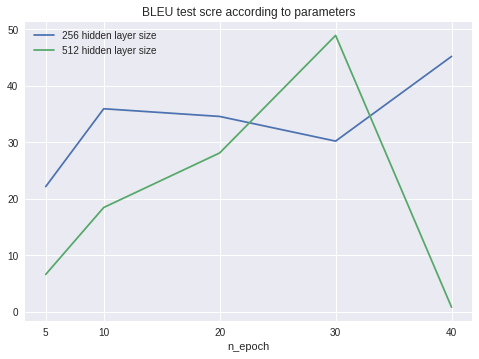

In [281]:
plt.plot([5, 10, 20, 30, 40],[float(str(k).split(' ')[2]) for k in bleu_scores_256], label = '256 hidden layer size')
plt.plot([5, 10, 20, 30, 40], [float(str(k).split(' ')[2]) for k in bleu_scores_512], label = '512 hidden layer size')
plt.xticks([5, 10, 20, 30, 40])
plt.xlabel('n_epoch')
plt.title('BLEU test scre according to parameters')
plt.legend()
plt.savefig('score_param')
plt.show()

In [283]:
# lets test the highest bleu score achieving model

model = seq2seqModel(encoder=EncoderRNN(VOC[langorder[0]]['nbwords'], n_hidden).to(device),
                            decoder=DecoderRNN(n_hidden, VOC[langorder[1]]['nbwords']).to(device), 
                            encoder_optimizer=optim.Adam,
                            decoder_optimizer=optim.Adam,
                            criterion=nn.CrossEntropyLoss(),
                            VOC=VOC)
        
loss_list, val_loss_list, bleu_scores, bert_scores = model.run_epochs(train_loader,
                                                              val_loader,
                                                              30,
                                                              learning_rate=0.001,
                                                              limit=200,
                                                              langorder=langorder, 
                                                              patience=40)

Epoch 0:: 100%|██████████| 200/200 [00:12<00:00, 16.00it/s]


Epoch 0 : Training : (loss 5.40737734545484) 


validation:: 100%|██████████| 200/200 [00:04<00:00, 45.05it/s]


validation : (loss 132.1287348175049) (blue BLEU = 6.59 73.7/5.6/2.9/1.6 (BP = 1.000 ratio = 1.000 hyp_len = 19 ref_len = 19))


Epoch 1:: 100%|██████████| 200/200 [00:13<00:00, 15.13it/s]


Epoch 1 : Training : (loss 4.775807005462674) 


validation:: 100%|██████████| 200/200 [00:03<00:00, 61.23it/s]


validation : (loss 82.86117244243621) (blue BLEU = 35.36 100.0/75.0/16.7/12.5 (BP = 1.000 ratio = 1.000 hyp_len = 5 ref_len = 5))


Epoch 2:: 100%|██████████| 200/200 [00:12<00:00, 15.93it/s]


Epoch 2 : Training : (loss 4.661497817692672) 


validation:: 100%|██████████| 200/200 [00:02<00:00, 73.21it/s]


validation : (loss 56.77271501541138) (blue BLEU = 17.50 89.2/41.7/8.6/2.9 (BP = 1.000 ratio = 1.000 hyp_len = 37 ref_len = 37))


Epoch 3:: 100%|██████████| 200/200 [00:12<00:00, 15.80it/s]


Epoch 3 : Training : (loss 4.24758301714215) 


validation:: 100%|██████████| 200/200 [00:03<00:00, 59.08it/s]


validation : (loss 89.02281190037728) (blue BLEU = 45.18 100.0/66.7/25.0/25.0 (BP = 1.000 ratio = 1.000 hyp_len = 4 ref_len = 4))


Epoch 4:: 100%|██████████| 200/200 [00:12<00:00, 15.95it/s]


Epoch 4 : Training : (loss 4.366117854580852) 


validation:: 100%|██████████| 200/200 [00:04<00:00, 40.29it/s]


validation : (loss 151.53310042858124) (blue BLEU = 22.42 100.0/45.5/10.0/5.6 (BP = 1.000 ratio = 1.000 hyp_len = 12 ref_len = 12))


Epoch 5:: 100%|██████████| 200/200 [00:12<00:00, 15.46it/s]


Epoch 5 : Training : (loss 4.3745383771159805) 


validation:: 100%|██████████| 200/200 [00:04<00:00, 48.31it/s]


validation : (loss 120.69527760982514) (blue BLEU = 59.46 100.0/75.0/66.7/25.0 (BP = 1.000 ratio = 1.000 hyp_len = 5 ref_len = 5))


Epoch 6:: 100%|██████████| 200/200 [00:14<00:00, 13.47it/s]


Epoch 6 : Training : (loss 4.36818804546483) 


validation:: 100%|██████████| 200/200 [00:03<00:00, 54.32it/s]


validation : (loss 101.31121795892716) (blue BLEU = 39.76 100.0/60.0/25.0/16.7 (BP = 1.000 ratio = 1.000 hyp_len = 6 ref_len = 6))


Epoch 7:: 100%|██████████| 200/200 [00:15<00:00, 13.03it/s]


Epoch 7 : Training : (loss 4.318909587241553) 


validation:: 100%|██████████| 200/200 [00:04<00:00, 42.03it/s]


validation : (loss 146.52934846639633) (blue BLEU = 10.18 49.3/20.5/6.0/2.0 (BP = 0.968 ratio = 0.968 hyp_len = 152 ref_len = 157))


Epoch 8:: 100%|██████████| 200/200 [00:14<00:00, 13.80it/s]


Epoch 8 : Training : (loss 4.411399432715278) 


validation:: 100%|██████████| 200/200 [00:04<00:00, 45.03it/s]


validation : (loss 128.71326657295228) (blue BLEU = 22.50 100.0/46.7/14.3/3.8 (BP = 1.000 ratio = 1.000 hyp_len = 16 ref_len = 16))


Epoch 9:: 100%|██████████| 200/200 [00:14<00:00, 14.13it/s]


Epoch 9 : Training : (loss 4.2139663176886915) 


validation:: 100%|██████████| 200/200 [00:05<00:00, 34.60it/s]


validation : (loss 199.74332837581633) (blue BLEU = 26.86 83.3/60.0/12.5/8.3 (BP = 1.000 ratio = 1.000 hyp_len = 6 ref_len = 6))


Epoch 10:: 100%|██████████| 200/200 [00:13<00:00, 14.43it/s]


Epoch 10 : Training : (loss 4.2561107287718505) 


validation:: 100%|██████████| 200/200 [00:04<00:00, 45.34it/s]


validation : (loss 128.51859014034272) (blue BLEU = 0.00 100.0/100.0/100.0/0.0 (BP = 1.000 ratio = 1.000 hyp_len = 3 ref_len = 3))


Epoch 11:: 100%|██████████| 200/200 [00:13<00:00, 14.32it/s]


Epoch 11 : Training : (loss 4.10584125928032) 


validation:: 100%|██████████| 200/200 [00:05<00:00, 38.41it/s]


validation : (loss 166.77849050998688) (blue BLEU = 14.61 76.5/25.0/6.7/3.6 (BP = 1.000 ratio = 1.000 hyp_len = 17 ref_len = 17))


Epoch 12:: 100%|██████████| 200/200 [00:12<00:00, 15.72it/s]


Epoch 12 : Training : (loss 3.9761360662105316) 


validation:: 100%|██████████| 200/200 [00:04<00:00, 42.40it/s]


validation : (loss 146.51482467293738) (blue BLEU = 100.00 100.0/100.0/100.0/100.0 (BP = 1.000 ratio = 1.000 hyp_len = 4 ref_len = 4))


Epoch 13:: 100%|██████████| 200/200 [00:13<00:00, 14.38it/s]


Epoch 13 : Training : (loss 4.021432987462395) 


validation:: 100%|██████████| 200/200 [00:04<00:00, 43.51it/s]


validation : (loss 143.79240552127362) (blue BLEU = 0.58 11.2/0.4/0.2/0.1 (BP = 0.983 ratio = 0.983 hyp_len = 116 ref_len = 118))


Epoch 14:: 100%|██████████| 200/200 [00:11<00:00, 17.35it/s]


Epoch 14 : Training : (loss 3.869092929948061) 


validation:: 100%|██████████| 200/200 [00:04<00:00, 44.99it/s]


validation : (loss 137.6829895210266) (blue BLEU = 47.29 100.0/50.0/40.0/25.0 (BP = 1.000 ratio = 1.000 hyp_len = 7 ref_len = 7))


Epoch 15:: 100%|██████████| 200/200 [00:13<00:00, 14.38it/s]


Epoch 15 : Training : (loss 3.870893358047249) 


validation:: 100%|██████████| 200/200 [00:05<00:00, 39.55it/s]


validation : (loss 160.28005395650862) (blue BLEU = 0.00 100.0/50.0/0.0/0.0 (BP = 1.000 ratio = 1.000 hyp_len = 2 ref_len = 2))


Epoch 16:: 100%|██████████| 200/200 [00:14<00:00, 13.68it/s]


Epoch 16 : Training : (loss 3.9626668016795388) 


validation:: 100%|██████████| 200/200 [00:04<00:00, 45.68it/s]


validation : (loss 135.15592620849608) (blue BLEU = 11.48 66.7/10.0/6.2/4.2 (BP = 1.000 ratio = 1.000 hyp_len = 6 ref_len = 6))


Epoch 17:: 100%|██████████| 200/200 [00:13<00:00, 14.65it/s]


Epoch 17 : Training : (loss 3.8767001087730533) 


validation:: 100%|██████████| 200/200 [00:04<00:00, 43.86it/s]


validation : (loss 141.4817468357086) (blue BLEU = 18.92 100.0/46.7/7.1/3.8 (BP = 1.000 ratio = 1.000 hyp_len = 16 ref_len = 16))


Epoch 18:: 100%|██████████| 200/200 [00:13<00:00, 15.10it/s]


Epoch 18 : Training : (loss 3.8096170775508216) 


validation:: 100%|██████████| 200/200 [00:04<00:00, 40.54it/s]


validation : (loss 154.2964645755291) (blue BLEU = 4.56 51.2/10.0/1.3/0.7 (BP = 1.000 ratio = 1.000 hyp_len = 41 ref_len = 41))


Epoch 19:: 100%|██████████| 200/200 [00:14<00:00, 13.89it/s]


Epoch 19 : Training : (loss 3.7959492116080105) 


validation:: 100%|██████████| 200/200 [00:03<00:00, 53.06it/s]


validation : (loss 108.56152248620987) (blue BLEU = 41.11 100.0/85.7/33.3/10.0 (BP = 1.000 ratio = 1.000 hyp_len = 8 ref_len = 8))


Epoch 20:: 100%|██████████| 200/200 [00:14<00:00, 13.95it/s]


Epoch 20 : Training : (loss 3.670542390917933) 


validation:: 100%|██████████| 200/200 [00:05<00:00, 34.06it/s]


validation : (loss 193.02490390777587) (blue BLEU = 26.27 100.0/28.6/16.7/10.0 (BP = 1.000 ratio = 1.000 hyp_len = 8 ref_len = 8))


Epoch 21:: 100%|██████████| 200/200 [00:14<00:00, 13.49it/s]


Epoch 21 : Training : (loss 3.768521305510343) 


validation:: 100%|██████████| 200/200 [00:03<00:00, 57.28it/s]


validation : (loss 93.67379908919334) (blue BLEU = 35.93 100.0/40.0/25.0/16.7 (BP = 1.000 ratio = 1.000 hyp_len = 6 ref_len = 6))


Epoch 22:: 100%|██████████| 200/200 [00:13<00:00, 14.48it/s]


Epoch 22 : Training : (loss 3.476180833074373) 


validation:: 100%|██████████| 200/200 [00:04<00:00, 42.52it/s]


validation : (loss 144.59307435035706) (blue BLEU = 7.65 56.3/14.3/5.8/0.7 (BP = 1.000 ratio = 1.014 hyp_len = 71 ref_len = 70))


Epoch 23:: 100%|██████████| 200/200 [00:13<00:00, 14.66it/s]


Epoch 23 : Training : (loss 3.655193586723117) 


validation:: 100%|██████████| 200/200 [00:05<00:00, 38.03it/s]


validation : (loss 170.84109492897989) (blue BLEU = 30.21 100.0/33.3/20.0/12.5 (BP = 1.000 ratio = 1.000 hyp_len = 7 ref_len = 7))


Epoch 24:: 100%|██████████| 200/200 [00:14<00:00, 14.17it/s]


Epoch 24 : Training : (loss 3.678982534898093) 


validation:: 100%|██████████| 200/200 [00:04<00:00, 44.92it/s]


validation : (loss 139.1122242486477) (blue BLEU = 41.11 85.7/66.7/40.0/12.5 (BP = 1.000 ratio = 1.000 hyp_len = 7 ref_len = 7))


Epoch 25:: 100%|██████████| 200/200 [00:14<00:00, 13.59it/s]


Epoch 25 : Training : (loss 3.83815828653153) 


validation:: 100%|██████████| 200/200 [00:04<00:00, 40.47it/s]


validation : (loss 153.94954893946647) (blue BLEU = 3.24 24.5/4.1/2.1/0.5 (BP = 1.000 ratio = 1.021 hyp_len = 98 ref_len = 96))


Epoch 26:: 100%|██████████| 200/200 [00:14<00:00, 13.41it/s]


Epoch 26 : Training : (loss 3.7063367248322705) 


validation:: 100%|██████████| 200/200 [00:04<00:00, 40.31it/s]


validation : (loss 156.9940474268794) (blue BLEU = 14.32 41.7/18.2/10.0/5.6 (BP = 1.000 ratio = 1.000 hyp_len = 12 ref_len = 12))


Epoch 27:: 100%|██████████| 200/200 [00:13<00:00, 14.87it/s]


Epoch 27 : Training : (loss 3.5274267775420465) 


validation:: 100%|██████████| 200/200 [00:04<00:00, 41.41it/s]


validation : (loss 157.08708824276925) (blue BLEU = 10.04 89.3/14.8/3.8/2.0 (BP = 1.000 ratio = 1.000 hyp_len = 28 ref_len = 28))


Epoch 28:: 100%|██████████| 200/200 [00:15<00:00, 13.08it/s]


Epoch 28 : Training : (loss 3.7658573270138347) 


validation:: 100%|██████████| 200/200 [00:05<00:00, 37.96it/s]


validation : (loss 178.08503632545472) (blue BLEU = 0.00 66.7/25.0/25.0/0.0 (BP = 1.000 ratio = 1.000 hyp_len = 3 ref_len = 3))


Epoch 29:: 100%|██████████| 200/200 [00:15<00:00, 12.75it/s]


Epoch 29 : Training : (loss 3.72600887968563) 


validation:: 100%|██████████| 200/200 [00:04<00:00, 46.30it/s]


validation : (loss 131.67445419311522) (blue BLEU = 29.07 100.0/42.9/16.7/10.0 (BP = 1.000 ratio = 1.000 hyp_len = 8 ref_len = 8))


In [293]:
to_test = df_test.original.values
to_check = df_test.modern.values
for i in np.random.choice(list(range(len(to_test))), 10):
    elt = to_test[i]
    print('original:','%s' % (colored(elt, 'blue')))
    print('modern: %s' % (colored(to_check[i], 'grey')))
    model.print_translation(model.evaluate(elt,input_lang='original_en',target_lang='modern_en')[0])

original: Is ’t come to this?
modern: Has it come to this?
<sos> what ’ possible ? <EOS>
original: I am mightily abused. I should ev'n die with pity To see another thus. I know not what to say. I will not swear these are my hands. Let’s see. I feel this pinprick. Would I were assured
modern: Where have I been? Where am I? Is it daytime? I’ve been tricked. I would die of pity to see someone else in my condition. I don’t know what to say. I can’t even be sure these are my hands. Let’s see. I feel this pinprick. I wish I knew what is happening.
<sos> i ’ ll be i i ’ i to ’ i ’ i to ’ i to ’ i to ’ i to ’ i ’ i to ’ i ’ i to ’ i ’ i to ’ i ’ i to ’ i ’ i ’ i
original: Macbeth.
modern: Macbeth.
<sos> show . <EOS>
original: Macduff is missing, and your noble son.
modern: Macduff is missing, and so is your noble son.
<sos> i ’ , , , , , , , , <EOS>
original:    Holds it true, sir, that the Duke of Cornwall was so slain?
modern: Is it true, sir, that the Duke of Cornwall was killed as they say

#### Second Dataset
<a class="anchor" id="2dataset"></a>


In [294]:
df2 = pd.read_csv('https://raw.githubusercontent.com/vdelale/NLP-ENSAE/main/data/lines.csv', index_col=0)

In [295]:
df2['modern_tok'] = df2['modern'].apply(lambda x: tok.tokenize(x.lower().strip()))
df2['original_tok'] = df2['original'].apply(lambda x: tok.tokenize(x.lower().strip()))

##### Vocabulary


In [296]:
VOC2 = {'original_en': {'stoi': {}, 'counts': {}, 'nbwords': 0}, 'modern_en': {'stoi': {}, 'counts': {}, 'nbwords': 0}}

In [297]:
LANGS = ['original_en', 'modern_en']
for lang in LANGS:
  for t in special_symbols: 
    VOC2[lang]['stoi'][t] = VOC2[lang]['nbwords']
    VOC2[lang]['counts'][t] = 1
    VOC2[lang]['nbwords'] += 1

In [298]:
tokens_modern = df2.modern_tok.values
for tokens in tokens_modern:
    for t in tokens:
        if t not in VOC2['modern_en']['stoi']: 
            VOC2['modern_en']['stoi'][t] = VOC2['modern_en']['nbwords']
            VOC2['modern_en']['counts'][t] = 1
            VOC2['modern_en']['nbwords'] += 1
        else:
            VOC2['modern_en']['counts'][t] = VOC2['modern_en']['counts'][t] + 1

In [299]:
tokens_original = df2.original_tok.values
for tokens in tokens_original:
    for t in tokens:
        if t not in VOC2['original_en']['stoi']: 
            VOC2['original_en']['stoi'][t] = VOC2['original_en']['nbwords']
            VOC2['original_en']['counts'][t] = 1
            VOC2['original_en']['nbwords'] += 1
        else:
            VOC2['original_en']['counts'][t] = VOC2['original_en']['counts'][t] + 1

In [300]:
for lang in LANGS:
  VOC2[lang]['itos'] = { v:k for k,v in VOC2[lang]['stoi'].items()}

In [301]:
print('modern_en', VOC2['modern_en']['nbwords'], 'original_en', VOC2['original_en']['nbwords'])

modern_en 10650 original_en 12841


In [302]:
def prepa(entry, lang, VOC=VOC):
    tokens_entry =   [SOS_IDX] + [ VOC[lang]['stoi'][t] for t in entry ] + [EOS_IDX]   
    return tokens_entry

In [303]:
df2['modern_en'] = df2['modern_tok'].apply(lambda x: prepa(x, 'modern_en', VOC=VOC2))

In [304]:
df2['original_en'] = df2['original_tok'].apply(lambda x: prepa(x, 'original_en', VOC=VOC2))

In [305]:
df2_train, other = train_test_split(df2, test_size=0.33, random_state=42)
df2_test, df2_val = train_test_split(other, test_size=0.5, random_state=42)

In [306]:
train_loader2 = DataLoader(OrModDataset(df2_train.reset_index()), batch_size=1, shuffle=True, drop_last=True)
val_loader2   = DataLoader(OrModDataset(df2_val.reset_index()), batch_size=1, shuffle=True, drop_last=True)
test_loader2  = DataLoader(OrModDataset(df2_test.reset_index()), batch_size=1, shuffle=True, drop_last=True)

##### model

In [307]:
hidden_size = 512
langorder = ['original_en', 'modern_en']
epochs = 30

model2 = seq2seqModel(encoder=EncoderRNN(VOC2[langorder[0]]['nbwords'], hidden_size).to(device),
                     decoder=DecoderRNN(hidden_size, VOC2[langorder[1]]['nbwords']).to(device), 
                     encoder_optimizer=optim.Adam,
                     decoder_optimizer=optim.Adam,
                     criterion=nn.CrossEntropyLoss(),
                     VOC=VOC2)

In [309]:
loss_list, val_loss_list, blues, berts = model2.run_epochs(train_loader2, val_loader2, epochs, learning_rate=0.001, limit=200,
                                            langorder=langorder, patience=20)

Epoch 0:: 100%|██████████| 200/200 [00:09<00:00, 20.14it/s]


Epoch 0 : Training : (loss 4.061792237306423) 


validation:: 100%|██████████| 200/200 [00:02<00:00, 95.10it/s] 


validation : (loss 38.096020617485046) (blue BLEU = 0.00 100.0/100.0/0.0/0.0 (BP = 1.000 ratio = 1.000 hyp_len = 2 ref_len = 2))


Epoch 1:: 100%|██████████| 200/200 [00:08<00:00, 24.26it/s]


Epoch 1 : Training : (loss 3.7997482345936566) 


validation:: 100%|██████████| 200/200 [00:02<00:00, 86.10it/s]


validation : (loss 47.148438735306264) (blue BLEU = 18.77 100.0/55.6/6.2/3.6 (BP = 1.000 ratio = 1.000 hyp_len = 10 ref_len = 10))


Epoch 2:: 100%|██████████| 200/200 [00:08<00:00, 24.00it/s]


Epoch 2 : Training : (loss 3.8007072365827725) 


validation:: 100%|██████████| 200/200 [00:02<00:00, 76.51it/s]


validation : (loss 59.51923643350601) (blue BLEU = 17.97 87.5/28.6/8.3/5.0 (BP = 1.000 ratio = 1.000 hyp_len = 8 ref_len = 8))


Epoch 3:: 100%|██████████| 200/200 [00:08<00:00, 24.60it/s]


Epoch 3 : Training : (loss 3.950113186269837) 


validation:: 100%|██████████| 200/200 [00:02<00:00, 86.85it/s]


validation : (loss 46.84449234008789) (blue BLEU = 24.27 83.3/40.0/12.5/8.3 (BP = 1.000 ratio = 1.000 hyp_len = 6 ref_len = 6))


Epoch 4:: 100%|██████████| 200/200 [00:08<00:00, 23.44it/s]


Epoch 4 : Training : (loss 3.9479315380823117) 


validation:: 100%|██████████| 200/200 [00:02<00:00, 88.95it/s]


validation : (loss 46.86314528286457) (blue BLEU = 47.29 100.0/60.0/50.0/16.7 (BP = 1.000 ratio = 1.000 hyp_len = 6 ref_len = 6))


Epoch 5:: 100%|██████████| 200/200 [00:08<00:00, 22.43it/s]


Epoch 5 : Training : (loss 4.027919537847198) 


validation:: 100%|██████████| 200/200 [00:02<00:00, 74.62it/s]


validation : (loss 58.488693289756775) (blue BLEU = 23.70 90.9/50.0/11.1/6.2 (BP = 1.000 ratio = 1.000 hyp_len = 11 ref_len = 11))


Epoch 6:: 100%|██████████| 200/200 [00:08<00:00, 22.59it/s]


Epoch 6 : Training : (loss 3.9378887497152744) 


validation:: 100%|██████████| 200/200 [00:02<00:00, 79.55it/s]


validation : (loss 54.8973478770256) (blue BLEU = 8.61 27.3/9.4/6.5/3.3 (BP = 1.000 ratio = 1.031 hyp_len = 33 ref_len = 32))


Epoch 7:: 100%|██████████| 200/200 [00:08<00:00, 24.61it/s]


Epoch 7 : Training : (loss 3.767809503544824) 


validation:: 100%|██████████| 200/200 [00:02<00:00, 76.71it/s]


validation : (loss 58.83318955123425) (blue BLEU = 70.71 100.0/75.0/66.7/50.0 (BP = 1.000 ratio = 1.000 hyp_len = 5 ref_len = 5))


Epoch 8:: 100%|██████████| 200/200 [00:08<00:00, 23.65it/s]


Epoch 8 : Training : (loss 3.8032640745610724) 


validation:: 100%|██████████| 200/200 [00:02<00:00, 85.73it/s]


validation : (loss 50.455550171136856) (blue BLEU = 10.12 70.6/25.0/3.3/1.8 (BP = 1.000 ratio = 1.000 hyp_len = 17 ref_len = 17))


Epoch 9:: 100%|██████████| 200/200 [00:08<00:00, 23.60it/s]


Epoch 9 : Training : (loss 3.9035028720642084) 


validation:: 100%|██████████| 200/200 [00:02<00:00, 89.20it/s]


validation : (loss 44.738402290940286) (blue BLEU = 37.99 100.0/33.3/25.0/25.0 (BP = 1.000 ratio = 1.000 hyp_len = 4 ref_len = 4))


Epoch 10:: 100%|██████████| 200/200 [00:08<00:00, 23.23it/s]


Epoch 10 : Training : (loss 3.8586244380740133) 


validation:: 100%|██████████| 200/200 [00:02<00:00, 71.68it/s]


validation : (loss 66.44360640406609) (blue BLEU = 16.52 100.0/25.0/7.1/4.2 (BP = 1.000 ratio = 1.000 hyp_len = 9 ref_len = 9))


Epoch 11:: 100%|██████████| 200/200 [00:08<00:00, 23.47it/s]


Epoch 11 : Training : (loss 3.916819657330245) 


validation:: 100%|██████████| 200/200 [00:02<00:00, 93.57it/s] 


validation : (loss 42.80642996788025) (blue BLEU = 63.89 100.0/66.7/50.0/50.0 (BP = 1.000 ratio = 1.000 hyp_len = 4 ref_len = 4))


Epoch 12:: 100%|██████████| 200/200 [00:09<00:00, 22.05it/s]


Epoch 12 : Training : (loss 3.796364965860187) 


validation:: 100%|██████████| 200/200 [00:02<00:00, 82.83it/s]


validation : (loss 51.94954725384712) (blue BLEU = 19.30 66.7/20.0/12.5/8.3 (BP = 1.000 ratio = 1.000 hyp_len = 6 ref_len = 6))


Epoch 13:: 100%|██████████| 200/200 [00:08<00:00, 24.91it/s]


Epoch 13 : Training : (loss 3.7923065511904457) 


validation:: 100%|██████████| 200/200 [00:02<00:00, 85.30it/s]


validation : (loss 51.04653755187988) (blue BLEU = 30.21 94.4/52.9/25.0/6.7 (BP = 1.000 ratio = 1.000 hyp_len = 18 ref_len = 18))


Epoch 14:: 100%|██████████| 200/200 [00:08<00:00, 23.81it/s]


Epoch 14 : Training : (loss 3.905530498270399) 


validation:: 100%|██████████| 200/200 [00:02<00:00, 87.50it/s]


validation : (loss 48.83284665465355) (blue BLEU = 42.73 80.0/50.0/33.3/25.0 (BP = 1.000 ratio = 1.000 hyp_len = 5 ref_len = 5))


Epoch 15:: 100%|██████████| 200/200 [00:08<00:00, 24.22it/s]


Epoch 15 : Training : (loss 3.6881364419727265) 


validation:: 100%|██████████| 200/200 [00:02<00:00, 89.71it/s]


validation : (loss 45.67054141581058) (blue BLEU = 15.64 68.2/33.3/10.0/2.6 (BP = 1.000 ratio = 1.048 hyp_len = 22 ref_len = 21))


Epoch 16:: 100%|██████████| 200/200 [00:08<00:00, 23.70it/s]


Epoch 16 : Training : (loss 3.6794259135091845) 


validation:: 100%|██████████| 200/200 [00:02<00:00, 74.19it/s]


validation : (loss 61.10321773529053) (blue BLEU = 17.11 82.4/43.8/6.7/3.6 (BP = 1.000 ratio = 1.000 hyp_len = 17 ref_len = 17))


Epoch 17:: 100%|██████████| 200/200 [00:08<00:00, 23.49it/s]


Epoch 17 : Training : (loss 3.836734130995824) 


validation:: 100%|██████████| 200/200 [00:02<00:00, 98.20it/s] 


validation : (loss 37.08352189719677) (blue BLEU = 34.57 85.7/66.7/20.0/12.5 (BP = 1.000 ratio = 1.000 hyp_len = 7 ref_len = 7))


Epoch 18:: 100%|██████████| 200/200 [00:07<00:00, 25.05it/s]


Epoch 18 : Training : (loss 3.6461923076245073) 


validation:: 100%|██████████| 200/200 [00:02<00:00, 77.05it/s]


validation : (loss 57.987095067501066) (blue BLEU = 17.78 70.8/21.7/13.6/4.8 (BP = 1.000 ratio = 1.000 hyp_len = 24 ref_len = 24))


Epoch 19:: 100%|██████████| 200/200 [00:08<00:00, 23.73it/s]


Epoch 19 : Training : (loss 3.7057049466948433) 


validation:: 100%|██████████| 200/200 [00:02<00:00, 80.56it/s]


validation : (loss 52.64687833070755) (blue BLEU = 10.58 42.9/20.0/5.3/2.8 (BP = 1.000 ratio = 1.000 hyp_len = 21 ref_len = 21))


Epoch 20:: 100%|██████████| 200/200 [00:08<00:00, 22.90it/s]


Epoch 20 : Training : (loss 3.8382476763876605) 


validation:: 100%|██████████| 200/200 [00:02<00:00, 80.46it/s]


validation : (loss 55.25099399089813) (blue BLEU = 59.46 100.0/75.0/66.7/25.0 (BP = 1.000 ratio = 1.000 hyp_len = 5 ref_len = 5))


Epoch 21:: 100%|██████████| 200/200 [00:08<00:00, 24.35it/s]


Epoch 21 : Training : (loss 3.654486324823827) 


validation:: 100%|██████████| 200/200 [00:02<00:00, 94.04it/s]


validation : (loss 41.53284923017025) (blue BLEU = 34.33 83.3/40.0/25.0/16.7 (BP = 1.000 ratio = 1.000 hyp_len = 6 ref_len = 6))


Epoch 22:: 100%|██████████| 200/200 [00:08<00:00, 24.09it/s]


Epoch 22 : Training : (loss 3.6718363723598966) 


validation:: 100%|██████████| 200/200 [00:02<00:00, 82.76it/s]


validation : (loss 50.638885581493376) (blue BLEU = 13.49 88.9/12.5/7.1/4.2 (BP = 1.000 ratio = 1.000 hyp_len = 9 ref_len = 9))


Epoch 23:: 100%|██████████| 200/200 [00:08<00:00, 23.17it/s]


Epoch 23 : Training : (loss 3.6487086796345722) 


validation:: 100%|██████████| 200/200 [00:02<00:00, 89.25it/s]


validation : (loss 45.708695998191835) (blue BLEU = 16.45 80.0/28.6/7.7/4.2 (BP = 1.000 ratio = 1.000 hyp_len = 15 ref_len = 15))


Epoch 24:: 100%|██████████| 200/200 [00:08<00:00, 24.09it/s]


Epoch 24 : Training : (loss 3.5688333317137744) 


validation:: 100%|██████████| 200/200 [00:02<00:00, 83.16it/s]


validation : (loss 55.75603936433792) (blue BLEU = 25.41 80.0/25.0/16.7/12.5 (BP = 1.000 ratio = 1.000 hyp_len = 5 ref_len = 5))


Epoch 25:: 100%|██████████| 200/200 [00:08<00:00, 22.65it/s]


Epoch 25 : Training : (loss 3.8228956193737895) 


validation:: 100%|██████████| 200/200 [00:02<00:00, 80.02it/s]


validation : (loss 55.329654462337494) (blue BLEU = 18.36 75.0/27.3/10.0/5.6 (BP = 1.000 ratio = 1.000 hyp_len = 12 ref_len = 12))


Epoch 26:: 100%|██████████| 200/200 [00:07<00:00, 25.07it/s]


Epoch 26 : Training : (loss 3.6158443849639896) 


validation:: 100%|██████████| 200/200 [00:02<00:00, 82.91it/s]


validation : (loss 51.13940990805626) (blue BLEU = 11.99 55.6/12.5/7.1/4.2 (BP = 1.000 ratio = 1.000 hyp_len = 9 ref_len = 9))


Epoch 27:: 100%|██████████| 200/200 [00:08<00:00, 23.06it/s]


Epoch 27 : Training : (loss 3.6361854950959804) 


validation:: 100%|██████████| 200/200 [00:02<00:00, 73.63it/s]


validation : (loss 65.29742508858442) (blue BLEU = 25.41 80.0/25.0/16.7/12.5 (BP = 1.000 ratio = 1.000 hyp_len = 5 ref_len = 5))


Epoch 28:: 100%|██████████| 200/200 [00:08<00:00, 24.04it/s]


Epoch 28 : Training : (loss 3.565712164293011) 


validation:: 100%|██████████| 200/200 [00:02<00:00, 85.40it/s]


validation : (loss 49.99364454656839) (blue BLEU = 25.41 87.5/28.6/16.7/10.0 (BP = 1.000 ratio = 1.000 hyp_len = 8 ref_len = 8))


Epoch 29:: 100%|██████████| 200/200 [00:08<00:00, 22.53it/s]


Epoch 29 : Training : (loss 3.7939082070298666) 


validation:: 100%|██████████| 200/200 [00:02<00:00, 77.42it/s]

validation : (loss 62.05733291685581) (blue BLEU = 14.92 100.0/22.2/6.2/3.6 (BP = 1.000 ratio = 1.000 hyp_len = 10 ref_len = 10))


In [311]:
to_test = df2_test.original.values
to_check = df2_test.modern.values
for i in np.random.choice(list(range(len(to_test))), 10):
    elt = to_test[i]
    print('original:','%s' % (colored(elt, 'blue')))
    print('modern: %s' % (colored(to_check[i], 'grey')))
    model.print_translation(model2.evaluate(elt,input_lang='original_en',target_lang='modern_en')[0])

original: O, let me think on Hastings and be gone To Brecknock, while my fearful head is on!
modern: Oh, let me remember what happened to Hastings and hurry to
<sos> oh , my father ’ s father with my father ’ s father a woman and my father ’ s father ’ s saying me a woman our king our place our place our place our place our place ; i ’ d never our my friends . <EOS>
original: As love is, my lord, before it loves.
modern: Like love, my lord, before it learns to love.
<sos> yes , my , , ’ , my my , my my , my my love . <EOS>
original: Have mind upon your health, tempt me no further.
modern: If you care about your health, you won’t push me any further.
<sos> don ’ t t , t , me , ’ t say . <EOS>
original: Sir, I never loved you much, but I ha’ praised ye When you have well deserved ten times as much As I have said you did.
modern: Sir, I wouldn’t say I was your friend, but I’ve praised you when you deserved ten times more praise than I gave.
<sos> i ’ ve never seen as a never never seen as

In [312]:
df2_test['pred'] = df2_test['original'].apply(lambda x: model2.evaluate(x,input_lang='original_en',target_lang='modern_en')[0])

df2_test['pred'] = df2_test['pred'].apply(lambda x: ' '.join( [ h for h in x if h not in ['<pad>', '<sos>', '<eos>', '<EOS>'] ] ))
bleu_score = bleu.corpus_score(list(df2_test['pred']), list(df2_test['modern']))

In [313]:
bleu_score

BLEU = 0.86 6.3/0.8/0.4/0.2 (BP = 1.000 ratio = 21.000 hyp_len = 63 ref_len = 3)

## Generation
<a class="anchor" id="generation"></a>

In [85]:
!pip install transformers --upgrade

In [86]:
from transformers import GPT2Tokenizer

In [314]:
from transformers import (
AutoModelWithLMHead, AutoConfig, Trainer, AutoTokenizer, TextDataset, DataCollatorForLanguageModeling,
TrainingArguments) 

def modelTrainer(text_path, epochs, model='gpt2', batch_size=8, cache_dir='cache', save_name=''):
    model = AutoModelWithLMHead.from_pretrained(model) 
    tokenizer = AutoTokenizer.from_pretrained('gpt2') 
    data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False) 
    train_dataset = TextDataset(tokenizer=tokenizer,
                                file_path=text_path,
                                block_size=256)
    training_args = TrainingArguments(output_dir="gpt2_fine_tune_{}/".format(save_name),
                                    num_train_epochs=epochs,
                                    per_device_train_batch_size=batch_size,
                                    warmup_steps=500,
                                    save_steps=2000,
                                    logging_steps=100)
    trainer = Trainer(model=model,
                      args=training_args,
                      data_collator=data_collator,
                      train_dataset=train_dataset)
    trainer.train() 
    trainer.save_model()

In [315]:
df['combined'] = '<s>' + df.modern + '</s>' + '>>>>' + '<p>' + df.original + '</p>'

In [316]:
df['combined'] = df.combined.to_csv('combined.txt', sep='\n', index=False)

In [317]:
modelTrainer('combined.txt', 10, model='gpt2', batch_size=8, cache_dir='cache', save_name='model_df1')

/usr/local/lib/python3.7/dist-packages/transformers/models/auto/modeling_auto.py:911: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  FutureWarning,
loading configuration file https://huggingface.co/gpt2/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/fc674cd6907b4c9e933cb42d67662436b89fa9540a1f40d7c919d0109289ad01.7d2e0efa5ca20cef4fb199382111e9d3ad96fd77b849e1d4bed13a66e1336f51
Model config GPT2Config {
  "_name_or_path": "gpt2",
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
 

Step,Training Loss
100,3.707700
200,3.237700
300,3.056500
400,2.948700
500,2.814400
600,2.794800
700,2.687100
800,2.618900
900,2.589300
1000,2.509900




Training completed. Do not forget to share your model on huggingface.co/models =)


Saving model checkpoint to gpt2_fine_tune_model_df1/
Configuration saved in gpt2_fine_tune_model_df1/config.json
Model weights saved in gpt2_fine_tune_model_df1/pytorch_model.bin


In [318]:
model = AutoModelWithLMHead.from_pretrained("/content/gpt2_fine_tune_model_df1")

/usr/local/lib/python3.7/dist-packages/transformers/models/auto/modeling_auto.py:911: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  FutureWarning,
loading configuration file /content/gpt2_fine_tune_model_df1/config.json
Model config GPT2Config {
  "_name_or_path": "/content/gpt2_fine_tune_model_df1",
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 12,
  "n_positions": 1024,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,


In [319]:
from transformers import pipeline

In [320]:
tokenizer = AutoTokenizer.from_pretrained('gpt2')

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/gpt2/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/fc674cd6907b4c9e933cb42d67662436b89fa9540a1f40d7c919d0109289ad01.7d2e0efa5ca20cef4fb199382111e9d3ad96fd77b849e1d4bed13a66e1336f51
Model config GPT2Config {
  "_name_or_path": "gpt2",
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 12,
  "n_positions": 1024,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": 

In [321]:
generator = pipeline('text-generation', model=model, tokenizer=tokenizer)

In [322]:
def paraphrased(text):
  return(generator('<s>' + text + '</s>' + '>>>>' + '<p>'))

In [332]:
def trim_paraphrase(paraphrased_sent):
  txt = paraphrased_sent[0]['generated_text'].split('</s>' + '>>>>' + '<p>')[1]

  return(txt) 

In [339]:
full_original_text = " ".join(df['original'].values)

In [346]:
for i in range(10):
  print(df['modern'].sample(1).values[0])
  t = trim_paraphrase(paraphrased(df['modern'].sample(1).values[0]))
  print(colored(t, 'blue'))
  print(colored(t in full_original_text, 'red'))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Rest easy in the meantime.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The sad things from the city. They have for ever been a source of all joy.</p>
<s>The two
False
Not yet, lieutenant. It’s not even ten o'clock. The general got rid of us early tonight so he could be with Desdemona.—I can’t blame him. He hasn’t spent the night with her yet, and she’s beautiful enough to be 

Jove’s
Jove is the head of the gods in Roman mythology.

Jove’s lover.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Pardon the villain, madam but you’ll not believe what I have seen tonight.</p>
False
Is that true? Then Desdemona and Othello will go back to Venice.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


What do they say about it? Why, what do they say that makes them even give half a share of thee? To hear how they go about
False
Yes, they are.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


So large a one, you say, with many cells and dungeons, Denmark being one.</p>
<
False
Musicians, start playing here. I’ll pay you for your trouble. Play something short that will put the general in a good mood.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Ha! What should we do? We said something—</p>
<s>He told us that he is sorry, and that they wanted to know
False
Yes, sir.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


My husband.</p>
<s>Do you know the difference, the difference, my lord?
False
Oh, the poor man!


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Your royal highness.</p>
<s>(offstage) Come on, let’s see who’s shouting. It’s Gertrude
False
down, and then say also that in Aleppo I once saw a Turk beating a Venetian, so I grabbed the Turk by the throat and hit him like this.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Is ’t you, Iago? Where was thy master? I have been
False
His beard was gray, right?


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Why,
True
Tom will chase them off.—Go away, you mongrels! Whether you bite to kill, Mastiff, greyhound, or ugly mutt,
A man’s mistress, he hath done too. I have often seen him in the streets, where he does groan at the unrighteousness of a villain. He
False
